In [1]:
#import required package
from __future__ import division
from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import *
import os
import re
import math
import PIL
from scipy import signal
from scipy import ndimage
from scipy import spatial
from scipy import stats
from scipy import interpolate
import traceback
import sys
import pickle
import warnings
import pandas as pd
from pprint import pprint
from sklearn.metrics import r2_score
#from osgeo import gdal
from pysptools import spectro
from collections import Counter
import csv
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#file mangement generates a list containing a pth to all hdr files of pre-processed observations
def get_all_processed_HDR_addresses(parentDirectory):
    observationFiles=[]
    
    for (dirpath, dirnames, filenames) in os.walk(parentDirectory):
        observationFiles.extend(filenames)
        break
    ObservationImageAddresses=[]
    
    hdrPattern=".hdr"
    for i in observationFiles:
        if re.search(hdrPattern,i):
            ObservationImageAddresses.append(parentDirectory+'/'+i)
    return ObservationImageAddresses

In [3]:
#read hrd files for wavlengths of all bands
def read_CRISM_Image_wavelengths(headerFileAddress):
    wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
    
    currentObservationHeader=envi.open(headerFileAddress)
    currentObservationImage=currentObservationHeader.open_memmap()
    currentObservationArray=np.array(currentObservationImage)
    #currentObservationArray=spectral.open_image(i)

    #read wavelengths from saved wavelength file
    with open (wavelengthFile, 'rb') as fp:
        wavelengthsOfCurrentObservation=pickle.load(fp)
    return currentObservationArray,wavelengthsOfCurrentObservation

In [4]:
#find index of wavelngth closest to given wavelength
def find_nearest(wavelength_list,value): #find wavelength value in list closest to given value
    idx = np.searchsorted(wavelength_list, value, side="left")
    if idx > 0 and (idx == len(wavelength_list) or math.fabs(value - wavelength_list[idx-1]) < math.fabs(value - wavelength_list[idx])):
        return wavelength_list[idx-1]
    else:
        return wavelength_list[idx]

def find_wavelength_index(wavelength_list,item): #return index of in the array
    first = 0
    last = len(wavelength_list)-1
    found = False
    while( first<=last and not found):
        mid = (first + last)//2
        if wavelength_list[mid] == item :
            found = True
        else:
            if item < wavelength_list[mid]:
                last = mid - 1
            else:
                first = mid + 1	
    return mid
def find_nearest_index(wavelength_list,wavelength): #get wavelength in index closest to gicen wavelength and return its index
    (nearest_index,nearest_wavelength)=min(enumerate(wavelength_list), key=lambda x: abs(x[1]-wavelength))
    return nearest_index
def find_nearest_index_for_list(wavelength_list,wavelengths): # find index of nearest value for a list of given values
    indices=[]
    for i in wavelengths:
        indices.append(find_nearest_index(wavelength_list,i))
    return indices

In [5]:
# given a hyperspectral datacube and wavelengths to serve as upper and lower thresholds subset the datacube along the spectral direction
def get_spectral_subset(datacube,wavelength_list,lower_threshold,upper_threshold): #returns spectral subset from lower to upper threshold ( 1.2 to 2.6 micrometer for CRISM IR)
    lower_threshold_index=find_wavelength_index(wavelength_list,lower_threshold)
    upper_threshold_index=find_wavelength_index(wavelength_list,upper_threshold)
    thresholdedDatacube=datacube[:,:,lower_threshold_index:upper_threshold_index+1]
    thresholdedWavelengthList=wavelength_list[lower_threshold_index:upper_threshold_index+1]
    return thresholdedDatacube,thresholdedWavelengthList

In [6]:
# return an array of objects of SLI files corresponding to different mineral spectra
def getspectralObjects(spectraDirectory):
    observationFiles=[]
    for (_,_,temporaryList) in os.walk(spectraDirectory):
        observationFiles.extend(temporaryList)
        break
    hdrPattern=".hdr$"
    spectralObjects=[]
    for i in observationFiles:
        if re.search(hdrPattern,i):
            currentFile=spectraDirectory+'/'+i
            currentSpectra=envi.open(currentFile)
            spectralObjects.append(currentSpectra)
    return spectralObjects,observationFiles

In [7]:
#given a spectral object and a wavelength list extract spectra resample them to the given wavelenght list resolution
def getResampledSpectra(spectralObject,wavelengthList):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    #find no of bands in CRISM image
    noOfBands=np.shape(wavelengthList)[0] 
    # calculate number of spectras
    noOfSpectra=np.shape(spectras)[0]
    # create an array to store the resampled spectras
    resampledSpectras=np.zeros((noOfSpectra,noOfBands))
    #create a resampler
    resampler=BandResampler(sourceWavelengthList,wavelengthList)
    #iterate over all spectra
    for i in range(noOfSpectra):
        #resample a spectra
        resampledSpectras[i,:]=resampler(spectras[i,:])
    return resampledSpectras,spectralObject.names

In [8]:
#given spectral object get original spectra and accompaning wavelength list
def getOriginalSpectra(spectralObject):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    
    return spectras,spectralObject.names,sourceWavelengthList

In [9]:
# threshold image at 2.6 micrometer
def preProcessImage(imageHeaderAddress): # given address of a CRISM header file, read the data, deal with NaN values and apply spectral subset
    datacube,wavelength_list=read_CRISM_Image_wavelengths(imageHeaderAddress) #read image and wavelength_list
    datacube=np.where(np.logical_and(datacube>0,datacube<1),datacube,0)
    lower_threshold_for_spectral_subset=1.0
    upper_threshold_for_spectral_subset=2.59 #define wavelength threshold (CRISM data too noisy post 2.6 micrometer)
    datacube,wavelength_list=get_spectral_subset(datacube,wavelength_list,lower_threshold_for_spectral_subset,upper_threshold_for_spectral_subset)
    return datacube,wavelength_list

In [10]:
#given a spectra apply a DoG(difference of gaussian) filter to the spectra with sigmas 7 and 4
def applyDoG(spectra,sigma1,sigma2):
    #apply gaussian filter with the first sigma
    gauss1Filtered=ndimage.gaussian_filter1d(spectra,sigma=sigma1)
    #apply gaussian filter with the second sigma
    gauss2Filtered=ndimage.gaussian_filter1d(spectra,sigma=sigma2)
    #calculate DoG
    differenceSpectra=np.abs(np.subtract(gauss2Filtered,gauss1Filtered))
    return differenceSpectra

In [11]:
#given the spectra and indices of minimas interpolate leniar segmaents between the minimas
def interpolateBetweenIndices(spectra,indices):
    global wavelengthList
    #create linear interpolator using wavelengths and reflectance at minima indices
    interpolator=interpolate.interp1d(wavelengthList[indices],spectra[indices],kind='linear')
    #get interpolated values at all indices
    interpolatedReflectance=interpolator(wavelengthList)
    return interpolatedReflectance

In [12]:
#given a spectra and fraction size apply a boxcar (moving average) filter of that size to the spectra
def applyBoxcarFilter(spectra,filterFraction):
    #get number of bands in the spectra
    bands=np.shape(spectra)[0]
    #compute size of the filter
    filterSize=int(math.floor(filterFraction*bands))
    #cimpute half filter size
    halfFilterSize=int(math.floor(filterSize/2))
    #symetrically pad the spectra with half the filter size on each end
    paddedSpectra=np.pad(spectra,pad_width=halfFilterSize,mode='symmetric')
    #create an empty array to store the filtered spectra
    filteredSpectra=np.zeros_like(spectra)
    #create a counter to store filtered value
    index=0
    #iterate in original spectra range  in the padded spectra
    for i in range(halfFilterSize,halfFilterSize+bands):
        #apply the filter and store the result
        filteredSpectra[index]=np.sum(paddedSpectra[i-halfFilterSize:i+halfFilterSize])/filterSize
        #increment the counter
        index=index+1
    return filteredSpectra

In [13]:
#given a signal and size of filter find the standard deviation signal
def getStandardDeviation(signal,windowSize):
    c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
    c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
    return np.sqrt(c2 - c1*c1)

In [14]:
#given a signal smmoth it adaptively
def adaptiveSmoothing(signal):
    #specify box car filter sizes 5% and 15%
    firstBoxCarSize=0.05
    secondBoxCarSize=0.15
    #specify the sigma and window fraction
    fraction1=1/15
    fraction2=1/25
    #specify the standard deviation for the diffrence of Gaussian filters
    sigma1=15
    sigma2=4
    #specify window size of standard deviation calculation
    stdWindowSize1=int(fraction1*np.shape(signal)[0])
    stdWindowSize2=int(fraction2*np.shape(signal)[0])
    #apply 2% box car filter twice
    boxcar2Spectra=applyBoxcarFilter(applyBoxcarFilter(signal,filterFraction=firstBoxCarSize),filterFraction=firstBoxCarSize)
    #apply 10% box car filter twice
    boxcar10Spectra=applyBoxcarFilter(applyBoxcarFilter(signal,filterFraction=firstBoxCarSize),filterFraction=firstBoxCarSize)
    #apply DoG on 2% box car
    dog2Spectra=applyDoG(boxcar2Spectra,sigma1,sigma2)
    #apply DoG on 10% box car
    dog10Spectra=applyDoG(boxcar10Spectra,sigma1,sigma2)
    #calculate standard deviation for both dog results
    dog2STD=getStandardDeviation(dog2Spectra,stdWindowSize1)
    dog10STD=getStandardDeviation(dog10Spectra,stdWindowSize2)
    #get smmothed spectra
    smothedSpectra=np.where(dog2STD<dog10STD,boxcar2Spectra,boxcar10Spectra)
    return smothedSpectra

In [15]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    #spectra/=np.max(np.abs(spectra),axis=0)
    #return spectra
    return (spectra - np.min(spectra))/np.ptp(spectra)

In [16]:
#given a spectra and the indices of local minimas find the maximas for each segment demarkated by two minimas
def getMaximas(spectra,minimaIndices):
    #add the end of the spectra to the list of minimas and sort
    minimaIndices.append(len(spectra)-1)
    minimaIndices.sort()
    #create an empty list to store maximas
    maximaIndices=[]
    #iterate from 1st to the penultimate element
    for i in range(len(minimaIndices)-1):
        #extract slice of the spectra
        spectralSlice=list(spectra[minimaIndices[i]:minimaIndices[i+1]])
        #extract slice of the hull
        #append the maxima in this segment to the list of maximas
        try:
            maximaIndices.append(spectralSlice.index(max(spectralSlice))+minimaIndices[i])
        except:
            pass
    return maximaIndices

In [17]:
#given a spectra and a hull for the spectra return pait indices marking areas of the spectra that rise aboive the hull
def getOverUnderHullSegments(spectra,hull):
    #and empty list to hold start and end index of segments over/under the hull and a flag to tell if the segment is above or below
    segmentMarkers=[]
    #subtract the hull from the input spectra
    differenceSpectra=np.subtract(spectra,hull)
    #get indices of crossover zeros in the difference spectra
    crossoverIndices=list(np.where(np.diff(np.signbit(differenceSpectra)))[0])
    #add the start and end of the spectra to the list of cross over points
    crossoverIndices.append(0)
    crossoverIndices.append(len(spectra)-1)
    #remove duplicates and sort
    crossoverIndices=list(set(crossoverIndices))
    crossoverIndices.sort()
    #iterate through segments marked by crossover points
    for i in range(len(crossoverIndices)-1):     
        #extract segment from the difference signal
        currentSegment=differenceSpectra[crossoverIndices[i]:crossoverIndices[i+1]]
        postivemagnitude=0
        negetivemagnitude=0
        #get maginutude of largest postive value in the segment
        try:
            postivemagnitude=np.max(currentSegment[np.where(currentSegment>0)[0]])
        except:
            postivemagnitude=0
        #get maginutude of largest postive value in the segment
        try:
            negetivemagnitude=abs(np.min(currentSegment[np.where(currentSegment<0)[0]]))
        except:
            negetivemagnitude=0    
        #calculate sum of the segment check if it is positve or negetive and add to the list
        if postivemagnitude>negetivemagnitude:
            segmentMarkers.append([crossoverIndices[i],crossoverIndices[i+1],1])
        else:
            segmentMarkers.append([crossoverIndices[i],crossoverIndices[i+1],-1])
    return differenceSpectra,segmentMarkers

In [18]:
#given a spectra,set of initial minima Points and an initial hull iteratively improve upon it
def generateIdealHull(spectra,initialHull,minimaIndices,hullIndices):
    #get markers for segments above or below the hull
    differenceSpectra,segmentMarkers=getOverUnderHullSegments(spectra,initialHull)
    for i in segmentMarkers:
        #get starting index of segment
        startIndex=i[0]
        #get ending index of segment
        endIndex=i[1]
        #over or under
        overUnderFlag=i[2]
        #if the flag is over add the maxima of that segment to the list of hull points and cross over points to minima indices
        if overUnderFlag==1:
            hullIndices.append(np.argmax(differenceSpectra[startIndex:endIndex])+startIndex)
            minimaIndices.append(startIndex)
            minimaIndices.append(endIndex)
    
    #remove duplicates from hull indices and minima indices and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    minimaIndices=list(set(minimaIndices))
    minimaIndices.sort()
    #interpolate between maximas to get the hull
    hull=interpolateBetweenIndices(spectra,hullIndices)
    return hullIndices,hull,minimaIndices

In [19]:
#given a spectra get hull points based on an alternate method
def getInitialHull(spectra):
    #apply  box car filter twice
    smoothedSpectra=adaptiveSmoothing(spectra)
    
    #calculate indices of minima for both versions of smoothed spectra
    minimaIndices=list(signal.argrelextrema(smoothedSpectra,np.less)[0])
    
    #calculate indices of maximas for smoothed spectra
    hullIndices=getMaximas(spectra,minimaIndices)
    
    #append the first and last point in the spectra to close the hull
    hullIndices.append(0)
    hullIndices.append(len(spectra)-1)
    hullIndices.sort()
    
    #interpolate between maximas to get the hull
    hull=interpolateBetweenIndices(spectra,hullIndices)
    
    return hullIndices,hull,minimaIndices

In [20]:
#given a spectra and indices of its hull points check if 2 or more hull points are between 2.1 and 2.4 micrometer
#if find all hull points with low smoothing ahead of the index corresponding to the hull point closest to 2.1 micrometer
def getOhHullPoints(crSpectra,hullPoints):
    #specify check range
    lowerWavelengthBound=2.1
    upperWavelengthBound=2.5
    #get wavlengths corresponding to hull points
    global wavelengthList
    hullPointWavelengths=wavelengthList[hullPoints]
    #get indices of hull points in the wavelength bound
    boundedIndices=np.array(hullPoints)[np.where(np.logical_and(hullPointWavelengths>=lowerWavelengthBound,hullPointWavelengths<=upperWavelengthBound))[0].tolist()]
    
    #check if there is only 1 elements if so return the original list of hull points
    if len(boundedIndices)<2:
        return hullPoints
    #calculate diffence between succesive indices
    indicesDifference=np.absolute(np.subtract(boundedIndices[:-1],boundedIndices[1:])).tolist()
    #check if all consecitive indices whose difference is less than 10 and return original list of hull points
    if all(i <10 for i in indicesDifference):
        return hullPoints
    
    #get the index for the first hull point in bounds
    breakPointIndex=boundedIndices[0]
    #extract portion of the continuum removed spectra after the breakPointIndex
    spectraSegment=applyBoxcarFilter(crSpectra,0.02)[breakPointIndex:]
    
    #get maxima indices
    maximaIndices=list(signal.argrelextrema(spectraSegment,np.greater)[0])
    return maximaIndices+breakPointIndex

In [21]:
#given a continuum removed spectra remove any segments that are less than 6 points wide or whose average value is more than 0.99
def removeNonSegments(crSpectra):
    #create an array to hold processed spectra
    processedSpectra=np.ones_like(crSpectra)
    #get hull point indices i.e where continuum removed spectra equals 1
    hullPointIndices=np.where(crSpectra==1)[0]
    #iterate between consecutive hull points
    for i in range(len(hullPointIndices)-1):
        #extract spectral slice between current pair of hull points
        currentSpectralSlice=crSpectra[hullPointIndices[i]:hullPointIndices[i+1]]
        #calculate length of current spectral slice
        sliceLength=np.shape(currentSpectralSlice)[0]
        #if length of the slice is more than 5 and mean is less than 0.95 keep the slice
        if sliceLength>5 and np.min(currentSpectralSlice)<0.99:
              processedSpectra[hullPointIndices[i]:hullPointIndices[i+1]]=currentSpectralSlice
    return processedSpectra

In [22]:
#given a continuum removed spectra identify maximas between consecutive hull points and set the maximum maxima whose value is also greater than an absolute threshold to be a hull points
def finalAdjustments(crSpectra,hullIndices):
    #set points in the continuum removed spectra at hull indices equal to 1
    crSpectra[hullIndices]=1.0
    return crSpectra,hullIndices

In [23]:
#given a spectra calculate the hull points and hull for using 2 different levels of smoothing and plot the results
def plotHull(normalizedSpectra):
    #get hull indices for both levels of smoothing
    hullIndices,hull,minimaIndices=getInitialHull(normalizedSpectra)
    #iteratively improve both hulls
    while(True):
        #save hulls from previous iterations
        prevHull=hull
        #improve the hull
        hullIndices,hull,minimaIndices=generateIdealHull(normalizedSpectra,hull,minimaIndices,hullIndices)
        #if no improvements occoured in the hull exit
        if (prevHull==hull).all():
            break
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #get OH hull points
    hullIndices.extend(getOhHullPoints(cr,hullIndices))
    #interpolate a hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #make final adjustments to the continuum removed spectra
    cr,hullIndices=finalAdjustments(cr,hullIndices)
    return cr

In [24]:
#given a datacube return its footprint i.e pixels in and out of the scene
def getDatacubeFootprint(datacube):
    [row,col,bands]=np.shape(datacube)
    #create an array to hold footprint of the image
    footprint=np.zeros_like(datacube[:,:,0])
    #get foot print of in scene pixels
    for i in range(row):
        for j in range(col):
            if 0==datacube[i,j,:].all():
                footprint[i,j]=1
    return footprint

In [25]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    upperLimit=1
    lowerLimit=0.0000001
    maximumValue=np.amax(spectra)
    minimumValue=np.amin(spectra)
    normalizedSpectra=(upperLimit-lowerLimit)*(spectra-minimumValue)/(maximumValue-minimumValue)+lowerLimit
    return normalizedSpectra

In [26]:
#given a continuum removed spectra get the start and ending points of all absorption features
def getHullPoints(crSpectra):
    #create a empty lists to store hull
    hullPoints=[]
    #get indices for all 1s n the continuum removed spectra
    onePoints=list(np.where(crSpectra==1)[0])
    for i in range(len(onePoints)-1):
        if onePoints[i]!=onePoints[i+1]-1 or onePoints[i-1]+1!=onePoints[i]:
            hullPoints.append(onePoints[i])
    #add starting and ending point of spectra
    hullPoints.append(0)
    hullPoints.append(np.shape(crSpectra)[0]-1)
    #remove any duplicates and sort
    hullPoints=list(set(hullPoints))
    hullPoints.sort()
    
    #create 2 empty lists to hold starting and ending points of absorption features
    startPoints=[]
    endPoints=[]
    for i in range(len(hullPoints)-1):
        #get a spectral slice between the ith and i+1th hull point
        spectralSlice=crSpectra[hullPoints[i]:hullPoints[i+1]]
        #if mean of spectral slice is more than 0.99 it is not an absorption feature
        if np.mean(spectralSlice)<0.99:
            startPoints.append(hullPoints[i])
            endPoints.append(hullPoints[i+1])
    return startPoints,endPoints

In [27]:
#given a continuum removed spectra extract each spectral feature and return 2 lists one of the spectra features and the other wavelengths for each feature
def getAbsorptionFeatures(crSpectra):
    global wavelengthList
    startPoints,endPoints=getHullPoints(crSpectra)
    #create two empty lists to hold reflectances and wavelengths for absorption features
    features=[]
    wavelengths=[]
    for i in range(len(startPoints)):
        featureReflectance=crSpectra[startPoints[i]:endPoints[i]+1]
        featureWavelengths=wavelengthList[startPoints[i]:endPoints[i]+1]
        features.append(featureReflectance)
        wavelengths.append(featureWavelengths)
    return features,wavelengths

In [28]:
#given a absorption feature get its parameters
def getAbsorbanceParametersPolynomial(currentWavelength,currentReflectance):
    #set number of points to interpolate on each side
    noOfPoints=20
    
    #get band centre as band minima
    bandCentre=currentWavelength[np.argmin(currentReflectance)]
    #get band depth
    bandDepth=np.max(currentReflectance)-currentReflectance[np.argmin(currentReflectance)]
    
    #create array to hold left half of the feature
    leftFeaturePoints=[]
    #create array to hold right half of the feature
    rightFeaturePoints=[]
    #create array to hold left half of wavelengths
    leftWavelengthPoints=[]
    #create array to hold right half of wavelengths
    rightWavelengthPoints=[]
    
    #check if there are set no. of points to the left of the band minima and extract 10 points to the left, if less than 10 extract all points
    if np.argmin(currentReflectance)>noOfPoints:
        leftFeaturePoints=currentReflectance[np.argmin(currentReflectance)-noOfPoints:np.argmin(currentReflectance)]
        leftWavelengthPoints=currentWavelength[np.argmin(currentReflectance)-noOfPoints:np.argmin(currentReflectance)]
    else:
        leftFeaturePoints=currentReflectance[:np.argmin(currentReflectance)]
        leftWavelengthPoints=currentWavelength[:np.argmin(currentReflectance)]
    #check if there are set no. of points to the right of the band minima and extract 10 points to the right, if less than 10 extract all points
    if np.argmin(currentReflectance)-np.shape(currentReflectance)[0]>noOfPoints:
        rightFeaturePoints=currentReflectance[np.argmin(currentReflectance):np.argmin(currentReflectance)-noOfPoints]
        rightWavelengthPoints=currentWavlength[np.argmin(currentReflectance):np.argmin(currentReflectance)-noOfPoints]
    else:
        rightFeaturePoints=currentReflectance[np.argmin(currentReflectance):]
        rightWavelengthPoints=currentWavelength[np.argmin(currentReflectance):]
    
    #combine the left and right lists
    wavelength=np.concatenate((leftWavelengthPoints,rightWavelengthPoints))
    reflectance=np.concatenate((leftFeaturePoints,rightFeaturePoints))
        
    
    #get step size as 1/4 of the difference between consecutive bands
    bandWidth=abs(wavelength[0]-wavelength[1])
    stepSize=bandWidth/4
    #generate list of interpolated wavelengths
    interpolatedWavelengths=np.arange(wavelength[0],wavelength[-1],stepSize)
    #fit a polynomial to the data
    polynomial=np.poly1d(np.polyfit(wavelength,reflectance,4))
    polynomialReflectance=polynomial(interpolatedWavelengths)
    #get band centre
    bandCentre=currentWavelength[np.argmin(currentReflectance)]
    #get band depth
    bandDepth=1-polynomial(bandCentre)
    if bandDepth>1:
        bandDepth=1
    return bandCentre,bandDepth,polynomialReflectance,interpolatedWavelengths

In [29]:
#given a half feature interpolate the feature to triple the number of points
def interpolateLowerFeature(lowerWavelength,lowerRelfectance):
    #get step size as 1/5 of the difference between consecutive bands
    bandWidth=abs(lowerWavelength[0]-lowerWavelength[1])
    stepSize=bandWidth/5
    #generate list of interpolated wavelengths
    interpolatedWavelengths=np.arange(lowerWavelength[0],lowerWavelength[-1],stepSize)
    #fit a polynomial to the data
    interpolator=interpolate.interp1d(lowerWavelength,lowerRelfectance,kind='cubic')
    interpolatedReflectance=interpolator(interpolatedWavelengths)
    return interpolatedWavelengths,interpolatedReflectance

In [30]:
#calculate absorption peaks for all features
def getFeatureParameters(wavelengths,reflectances):
    #create empty lists to hold band centres,band depths,fwhm, and left & right shoulders
    bandCentres=[]
    bandDepths=[]
    leftShoulders=[]
    rightShoulders=[]
    bandMinimas=[]
    #iterate over each feature

    for i in range(len(reflectances)):
        currentWavelength=wavelengths[i]
        currentReflectance=reflectances[i]
        #interpolate the feature if not possible use the original feature
        try:
            currentWavelength,currentReflectance=interpolateLowerFeature(currentWavelength,currentReflectance)
        except:
            pass
        #get lower half of the feature
        #get band centre
        bandCentre=currentWavelength[np.argmin(currentReflectance)]
        #get band depth
        bandDepth=np.max(currentReflectance)-currentReflectance[np.argmin(currentReflectance)]

        #get parameters for polynomial fit
        featureBandCentre,featureBandDepth,fittedReflectance,fittedWavelength=getAbsorbanceParametersPolynomial(currentWavelength,currentReflectance)


        #append parameters
        try:
            bandCentres.append(featureBandCentre[0])
        except:
            bandCentres.append(featureBandCentre)
        try:
            bandDepths.append(featureBandDepth[0])
        except:
            bandDepths.append(featureBandDepth)
        leftShoulders.append(wavelengths[i][0])
        rightShoulders.append(wavelengths[i][-1])
    #return featureBandCentre,featureBandDepth,fwhm,fittedReflectance,fittedWavelength,bandMinimas
    return bandCentres,bandDepths,leftShoulders,rightShoulders

In [98]:
#given lists corresponding to spectral parameters for n features of a sample spectra. Check, if the sample is a carbonate
def checkForCarbonate(bandCentres,bandDepths,leftShoulders,rightShoulders):
    #specify range of acceptable values
    bandCentre23LowerLimit=2.285
    bandCentre23UpperLimit=2.345
    bandCentre25LowerLimit=2.485
    bandCentre25UpperLimit=2.545
    interBandGapLowerLimit=0.19
    interBandGapUpperLimit=0.22
    
    #specify ideal band centre values for Fe and Mg carbonates
    feFirstIdealBandCentre=2.33
    feSecondIdealBandCentre=2.53
    mgFirstIdealBandCentre=2.30
    mgSecondIdealBandCentre=2.50
    #specify ideal value for inter band gap
    idealInterBandGap=0.20
    
    #specify range of acceptable values
    bandCentre23LowerLimit=2.27
    bandCentre23UpperLimit=2.39
    bandCentre25LowerLimit=2.47
    bandCentre25UpperLimit=2.58
    interBandGapLowerLimit=0.15
    interBandGapUpperLimit=0.23

    #specify ideal band centre values for Fe and Mg carbonates
    feFirstIdealBandCentre=2.33
    feSecondIdealBandCentre=2.53
    mgFirstIdealBandCentre=2.30
    mgSecondIdealBandCentre=2.50
    
    #create a flag to check if the sample is carbonate
    carbonateFlag=False
    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(bandCentres)
    
    #iterate over all features
    for i in range(noOfFeatures):
        if i<noOfFeatures-1 and bandCentres[i]<=bandCentre23UpperLimit and bandCentres[i]>=bandCentre23LowerLimit and bandCentres[i+1]<=bandCentre25UpperLimit and bandCentres[i+1]>=bandCentre25LowerLimit and abs(bandCentres[i]-bandCentres[i+1])<=interBandGapUpperLimit and abs(bandCentres[i]-bandCentres[i+1])>=interBandGapLowerLimit:
            firstCO3FeatureIndex=i
            carbonateFlag=True
    
    #if sample is carbonate classify as Iron/Calcium or Magnesium
    if carbonateFlag:
        #calculate distances from ideal Iron band centres
        fe23Distance=abs(feFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        fe25Distance=abs(feSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        feDistanceFromIdeal=max(fe23Distance,fe25Distance)
        #calcualte distances from ideal Magnesium band centres
        mg23Distance=abs(mgFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        mg25Distance=abs(mgSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        mgDistanceFromIdeal=max(mg23Distance,mg25Distance)
        #check which recorded distance is lesser, mark as that carbonate
        if mgDistanceFromIdeal<feDistanceFromIdeal:
            return 1 #flag for Mg carbonte
        else:
            return 2 #flag for Fe carbonte
    return 0 #flag for non carboante

In [32]:
#given lists corresponding to band centres, band depth and fwhms of all features in a spectra find  2.3 and 2.5 mircon feature for fe/CaCO3 check inter band gap between two and classify the sample as Fe/CaCO# or not
def checkCarbonateAdaptive(bandCentres,bandDepths,fwhms,bandCentreThreshold,InterBandGapThreshold):
    ##specify ideal band centre values for Fe and Mg carbonates
    feFirstIdealBandCentre=2.33
    feSecondIdealBandCentre=2.53
    mgFirstIdealBandCentre=2.30
    mgSecondIdealBandCentre=2.50
    #specify ideal value for inter band gap
    idealInterBandGap=0.20
    
    #specify range of acceptable values
    bandCentre23LowerLimit=min(mgFirstIdealBandCentre,feFirstIdealBandCentre)-bandCentreThreshold
    bandCentre23UpperLimit=max(mgFirstIdealBandCentre,feFirstIdealBandCentre)+bandCentreThreshold
    bandCentre25LowerLimit=min(mgSecondIdealBandCentre,feSecondIdealBandCentre)-bandCentreThreshold
    bandCentre25UpperLimit=max(mgSecondIdealBandCentre,feSecondIdealBandCentre)+bandCentreThreshold
    interBandGapLowerLimit=idealInterBandGap-InterBandGapThreshold
    interBandGapUpperLimit=idealInterBandGap+InterBandGapThreshold
    
    
    #create a flag to check if the sample is carbonate
    carbonateFlag=False
    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(fwhms)
    
    #iterate over all features
    for i in range(noOfFeatures):
        if i<noOfFeatures-1 and bandCentres[i]<=bandCentre23UpperLimit and bandCentres[i]>=bandCentre23LowerLimit and bandCentres[i+1]<=bandCentre25UpperLimit and bandCentres[i+1]>=bandCentre25LowerLimit and abs(bandCentres[i]-bandCentres[i+1])<=interBandGapUpperLimit and abs(bandCentres[i]-bandCentres[i+1])>=interBandGapLowerLimit:
            firstCO3FeatureIndex=i
            carbonateFlag=True
    
    #if sample is carbonate classify as Iron/Calcium or Magnesium
    if carbonateFlag:
        #calculate distances from ideal Iron band centres
        fe23Distance=abs(feFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        fe25Distance=abs(feSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        feDistanceFromIdeal=max(fe23Distance,fe25Distance)
        #calcualte distances from ideal Magnesium band centres
        mg23Distance=abs(mgFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        mg25Distance=abs(mgSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        mgDistanceFromIdeal=max(mg23Distance,mg25Distance)
        #check which recorded distance is lesser, mark as that carbonate
        if mgDistanceFromIdeal<feDistanceFromIdeal:
            return 1 #flag for Mg carbonte
        else:
            return 2 #flag for Fe carbonte
    return 0 #flag for non carboante

In [33]:
#given lists corresponding to band centres, band depth and fwhms of all features in a spectra find  1.4 and 1.9 mircon feature for phyllosilicates check and classify the sample as Phyllosilicate or not
def checkPhyllosilicate(bandCentres,bandDepths,fwhms):
    #specify acceptable ranges
    bandCentre14LowerLimit=1.33
    bandCentre14UpperLimit=1.44
    bandCentre19LowerLimit=1.89
    bandCentre19UpperLimit=1.96
    fwhm14LowerLimit=0.019
    fwhm14UpperLimit=0.263
    fwhm19LowerLimit=0.02
    fwhm19UpperLimit=0.15
    # create variables to hold indices for relavent features
    feature14Index=-1
    feature19Index=-1
    for i in range(len(bandCentres)):
        #check for 1.9 micron feature
        if bandCentres[i]<=bandCentre14UpperLimit and bandCentres[i]>=bandCentre14LowerLimit and fwhms[i]<=fwhm14UpperLimit and fwhms[i]>=fwhm14LowerLimit and feature14Index==-1:
            print("First phyllo. feature at index: "+str(i))
            feature14Index=i
        #check for 1.9 micron feature
        elif bandCentres[i]<=bandCentre19UpperLimit and bandCentres[i]>=bandCentre19LowerLimit and fwhms[i]<=fwhm19UpperLimit and fwhms[i]>=fwhm19LowerLimit and feature19Index==-1:
            print("First phyllo. feature at index: "+str(i))
            feature19Index=i
    #check if both features found if so return True
    if feature14Index>=0 and feature19Index>=0:
        return True
    return False

In [34]:
#given a preprocessed and normalized spectra and its name process it and classify as Carbonate type or not carbonate
def processSpectra(spectra):
    spectra=normalizeSpectra(spectra)
    cr=plotHull(spectra)
    features,wavelengths=getAbsorptionFeatures(plotHull(spectra))
    tempFeat=[]
    tempWavelengths=[]
    for i in range(len(wavelengths)):
        if len(wavelengths[i])>7:
            tempFeat.append(features[i])
            tempWavelengths.append(wavelengths[i])
    features=tempFeat
    wavelengths=tempWavelengths
    #get spectral paramerters
    bandCentres,bandDepths,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
    #remove any absorption features that have no band depth i.e. band depth==0
    tempFeat=[]
    tempWavelengths=[]
    tempBandCentres=[]
    tempBandDepths=[]
    tempLeftShoulders=[]
    tempRightShoulders=[]
    for i in range(len(wavelengths)):
        if bandDepths[i]>0.005:
            tempFeat.append(features[i])
            tempWavelengths.append(wavelengths[i])
            tempBandCentres.append(bandCentres[i])
            tempBandDepths.append(bandDepths[i])
            tempLeftShoulders.append(leftShoulders[i])
            tempRightShoulders.append(rightShoulders[i])
    features=tempFeat
    wavelengths=tempWavelengths
    bandCentres=tempBandCentres
    bandDepths=tempBandDepths
    leftShoulders=tempLeftShoulders
    rightShoulders=tempRightShoulders
    #check if there are at least two absorption features if not return Not carbonate
    if len(bandCentres)<2:
        return 0
    #check carbonate flag
    co3Flag=checkForCarbonate(bandCentres,bandDepths,leftShoulders,rightShoulders)
    if co3Flag==0:
        #print("Not CO3")
        return 0
    elif co3Flag==1:
        #print("MgCO3")
        return 1
    else:
        #print("FeCO3")
        return 2

In [35]:
#calulate mean reflectance at wavelength with defined kernel size for a single spectra
def calculateReflectanceAtWavelengthForSpectra(wavelength,spectra,kernelSize):
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    reflectance=spectra[targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        reflectance=reflectance+spectra[i]
    reflectance=reflectance-spectra[targetWavelengthIndex]
    return reflectance/kernelSize

In [36]:
#calculate band depth based indices for Fe and Ca/Mg rich carbonates
def calculateCarbonateBandDepthIndicesForSpectra(spectra):
    global wavelengthList
    R2345Wavelength=2.345 #define constant values to calculate indices, wavelengths, and kernel size 
    R2250Wavelength=2.250
    R2430Wavelength=2.430
    R2537Wavelength=2.537
    R2602Wavelength=2.590#2.602

    R2345KernelSize=5
    R2250KernelSize=5
    R2430KernelSize=5
    R2602KernelSize=1
    R2537KernelSize=5

    R2295Wavelength=2.295
    R2165Wavelength=2.165
    R2364Wavelength=2.364
    R2480Wavelength=2.480
    R2570Wavelength=2.570

    R2295KernelSize=5
    R2165KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    R2570KernelSize=5


    bForR2430=(R2345Wavelength-R2250Wavelength)/(R2430Wavelength-R2250Wavelength)
    aForR2250=1-bForR2430
    bForR2602=(R2537Wavelength-R2430Wavelength)/(R2602Wavelength-R2430Wavelength)
    aForR2430=1-bForR2602

    bForR2364=(R2295Wavelength-R2165Wavelength)/(R2364Wavelength-R2165Wavelength)
    aForR2165=1-bForR2364
    bForR2570=(R2480Wavelength-R2364Wavelength)/(R2570Wavelength-R2364Wavelength)
    aForR2364=1-bForR2570
    
    
    R2295Reflectance=calculateReflectanceAtWavelengthForSpectra(R2295Wavelength,spectra,R2295KernelSize) #read bands corresponding to wavelengths
    R2165Reflectance=calculateReflectanceAtWavelengthForSpectra(R2165Wavelength,spectra,R2165KernelSize)
    R2364Reflectance=calculateReflectanceAtWavelengthForSpectra(R2364Wavelength,spectra,R2364KernelSize)
    R2480Reflectance=calculateReflectanceAtWavelengthForSpectra(R2480Wavelength,spectra,R2480KernelSize)
    R2570Reflectance=calculateReflectanceAtWavelengthForSpectra(R2570Wavelength,spectra,R2570KernelSize)

    temp1Den=aForR2165*R2165Reflectance+bForR2364*R2364Reflectance # calculation for MIN2295_2480 minimum band depth at 2.3 and 2.5 micrometer 
    temp2Den=aForR2364*R2364Reflectance+bForR2570*R2570Reflectance
    temp3=2
    
    temp1=R2295Reflectance/temp1Den
    temp1=1-temp1
    temp3=2
    temp2=R2480Reflectance/temp2Den
    temp2=1-temp2
    MIN2295_2480=min(temp1,temp2)
    
    R2345Reflectance=calculateReflectanceAtWavelengthForSpectra(R2345Wavelength,spectra,R2345KernelSize) #read bands corresponding to wavelengths
    R2250Reflectance=calculateReflectanceAtWavelengthForSpectra(R2250Wavelength,spectra,R2250KernelSize)
    R2430Reflectance=calculateReflectanceAtWavelengthForSpectra(R2430Wavelength,spectra,R2430KernelSize)
    R2537Reflectance=calculateReflectanceAtWavelengthForSpectra(R2537Wavelength,spectra,R2537KernelSize)
    R2602Reflectance=calculateReflectanceAtWavelengthForSpectra(R2602Wavelength,spectra,R2602KernelSize)
    
    temp1Den=aForR2250*R2250Reflectance+bForR2430*R2430Reflectance # calculation for MIN2345_2537 minimum band depth at 2.33 and 2.53 micrometer
    temp2Den=aForR2430*R2250Reflectance+bForR2602*R2602Reflectance
    temp3=np.full_like(R2345Reflectance,2.0)
    
    temp1=R2345Reflectance/temp1Den
    temp1=1-temp1
    temp3=2.0
    temp2=R2537Reflectance/temp2Den
    temp2=1-temp2
    MIN2345_2537=min(temp1,temp2)
    
    return MIN2295_2480,MIN2345_2537

In [157]:
#given a spectrum check if it is a carbonate based on the values for the 2.3 and 2.5 micron band centres
def checkCarbonateBandCentreBased(scaledSpectra):
    #create flag to indicate carbonate or not
    carbonateFlag=False
    
    #remove continuum and get the band centres
    crSpectra=plotHull(scaledSpectra)
    features,wavelengths=getAbsorptionFeatures(crSpectra)
    tempFeat=[]
    tempWavelengths=[]
    for i in range(len(wavelengths)):
        if len(wavelengths[i])>7:
            tempFeat.append(features[i])
            tempWavelengths.append(wavelengths[i])
    features=tempFeat
    wavelengths=tempWavelengths
    #get spectral paramerters
    bandCentres,bandDepths,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
    #remove any absorption features that have no band depth i.e. band depth==0
    tempFeat=[]
    tempWavelengths=[]
    tempBandCentres=[]
    tempBandDepths=[]
    tempLeftShoulders=[]
    tempRightShoulders=[]
    for i in range(len(wavelengths)):
        if bandDepths[i]>0.005:
            tempFeat.append(features[i])
            tempWavelengths.append(wavelengths[i])
            tempBandCentres.append(bandCentres[i])
            tempBandDepths.append(bandDepths[i])
            tempLeftShoulders.append(leftShoulders[i])
            tempRightShoulders.append(rightShoulders[i])
    features=tempFeat
    wavelengths=tempWavelengths
    bandCentres=tempBandCentres
    bandDepths=tempBandDepths
    leftShoulders=tempLeftShoulders
    rightShoulders=tempRightShoulders
    
    #specify acceptable ranges of band-centre values
    mgCO323BandCentreLowerLimit=2.29
    mgCO323BandCentreUpperLimit=2.31
    
    feCO323BandCentreLowerLimit=2.32
    feCO323BandCentreUpperLimit=2.34
    
    mgCO325BandCentreLowerLimit=2.49
    mgCO325BandCentreUpperLimit=2.51
    
    feCO325BandCentreLowerLimit=2.52
    feCO325BandCentreUpperLimit=2.54
    
    #create flags to check if the 2.3 and 2.5 micron features are present
    mgCO323FeatureFlag=False
    mgCO325FeatureFlag=False
    feCO323FeatureFlag=False
    feCO325FeatureFlag=False
    
    #check if the mgCO3 2.3 micron feature is present
    if any ((currentBandCentre>=mgCO323BandCentreLowerLimit and currentBandCentre<=mgCO323BandCentreUpperLimit) for currentBandCentre in bandCentres):
        mgCO323FeatureFlag=True
    
    #check if the feCO3 2.3 micron feature is present
    if any ((currentBandCentre>=feCO323BandCentreLowerLimit and currentBandCentre<=feCO323BandCentreUpperLimit) for currentBandCentre in bandCentres):
        feCO323FeatureFlag=True
    
    #check if the mgCO3 2.5 micron feature is present
    if any ((currentBandCentre>=feCO325BandCentreLowerLimit and currentBandCentre<=feCO325BandCentreUpperLimit) for currentBandCentre in bandCentres):
        feCO325FeatureFlag=True
    
    #check if the feCO3 2.3 micron feature is present
    if any ((currentBandCentre>=mgCO325BandCentreLowerLimit and currentBandCentre<=mgCO325BandCentreUpperLimit) for currentBandCentre in bandCentres):
        mgCO325FeatureFlag=True
    
    #check if both features are present if they are update the carbonate flag
    if mgCO323FeatureFlag and mgCO325FeatureFlag:
        carbonateFlag=True
    if feCO323FeatureFlag and feCO325FeatureFlag:
        carbonateFlag=True
    
    return carbonateFlag

In [37]:
#read the wavelength list of an atmospherically corrected C
headerFileAddress="K:/Atmospherically Corrected CRISM images/frs00036f60_01_if169l_trr3_CAT_corr.hdr"
currentObservationHeader=envi.open(headerFileAddress)
fullWavelengthList=np.asarray(currentObservationHeader.bands.centers)
del currentObservationHeader
#subset the wavlength list to the same range as the denosised samples
lowerThresholdForSpectralSubset=1.0
upperThresholdForSpectralSubset=2.62
wavelengthList=fullWavelengthList[find_nearest_index(fullWavelengthList,lowerThresholdForSpectralSubset)+2:find_nearest_index(fullWavelengthList,upperThresholdForSpectralSubset)+1]


In [38]:
#create an array to hold names of mineral end-members of labels
labelNames=["CO2-Ice","H2O-Ice","Gypsum","Ferric-hydroxysulphate","Hematite",
            "Fe-smectite","Mg-smectite","Prehnite","Jarosite","Serpentine",
            "Alunite","Akaganeite","Ca/Fe-CO3","Al-Smectite-1","Kaolinite",
            "Bassanite","Epidote","Al-smectite-2","Polyhydrated-sulphate","None",
            "None","None","Illite","None","Analcime",
            "Monohydrated-sulphate","Hydrated-silica","None","Ferricopiapite","Mg-CO3",
            "Chlorite","None","Low-Calcium-Pyroxene","Mg-Olivine","High-Calcium-Pyroxene",
            "Fe-Olivine","Chloride","2.1-μm-artifact","Bland"]

In [99]:
#specify the directory containing all the samples
labelledDenoisedSamplesDirectory="K:/Martian Labelled Spectra"
#get list of all files in the directory
allSampleFiles=os.listdir(labelledDenoisedSamplesDirectory)
#create lists to hold spectra,original label, and predicted label, image, id of spectra and coordinates in image
allActualLabels=[]
allPredictedLabels=[]
allSpectra=[]
allSpectraIDs=[]
allImageIDs=[]
allXCoordinates=[]
allYCoordinates=[]
#iterate over all samples
for i in range(len(allSampleFiles)):
    #read the current file
    currentCSVFileAddress=labelledDenoisedSamplesDirectory+"/"+allSampleFiles[i]
    currentFile=open(currentCSVFileAddress)
    currentCSVReader=csv.reader(currentFile)
    #read the spectra from the CSV file
    currentSpectrum=[]
    for currentRow in currentCSVReader:
        if len(currentRow)>0:
            currentSpectrum=((np.asarray(currentRow)).astype(float))
            break
    currentFile.close()
    #scale the spectrum
    scaledSpectrum=normalizeSpectra(currentSpectrum)
    #process the spectra i.e. check for carbonate
    predictedLabel=-1
    try:
        predictedLabel=processSpectra(scaledSpectrum)
    except:
        pass
    
    #get the ID of the spectra
    sampleID=allSampleFiles[i][:allSampleFiles[i].index('_')]
    #get the actual label
    actualLabel=allSampleFiles[i][allSampleFiles[i].rindex('_')+1:allSampleFiles[i].index('.')]
    #get the Image ID
    imageID=allSampleFiles[i][allSampleFiles[i].index('_')+1:allSampleFiles[i].index('.')]
    imageID=imageID[:imageID.index('_')]
    #get the row number
    rowNumber=allSampleFiles[i][allSampleFiles[i].index('_')+1:allSampleFiles[i].index('.')]
    rowNumber=rowNumber[rowNumber.index('_')+1:]
    rowNumber=rowNumber[:rowNumber.index('_')]
    #get the column number
    colNumber=allSampleFiles[i][allSampleFiles[i].index('_')+1:allSampleFiles[i].index('.')]
    colNumber=colNumber[:colNumber.rindex('_')]
    colNumber=colNumber[colNumber.rindex('_')+1:]
    
    #save the actual label 
    allActualLabels.append(actualLabel)
    #save the predicted label to a list
    allPredictedLabels.append(predictedLabel)
    #save the spectrum
    allSpectra.append(scaledSpectrum)
    #save the ID of the sample
    allSpectraIDs.append(sampleID)
    #save the ID of the image from which the sample is taken
    allImageIDs.append(imageID)
    #save the number of the row from which the sample is taken
    allXCoordinates.append(rowNumber)
    #save the number of the column from which the sample is taken
    allYCoordinates.append(colNumber)

    if i%25000==0:
        print(f"{i}-Spectra processed. {i*100/len(allSampleFiles)}% Done")

C:\Users\104D\AppData\Local\Temp/ipykernel_6676/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_6676/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


0-Spectra processed. 0.0% Done
25000-Spectra processed. 4.464676373468393% Done
50000-Spectra processed. 8.929352746936786% Done
75000-Spectra processed. 13.394029120405179% Done
100000-Spectra processed. 17.858705493873572% Done
125000-Spectra processed. 22.323381867341965% Done
150000-Spectra processed. 26.788058240810358% Done
175000-Spectra processed. 31.25273461427875% Done
200000-Spectra processed. 35.717410987747144% Done
225000-Spectra processed. 40.18208736121554% Done
250000-Spectra processed. 44.64676373468393% Done
275000-Spectra processed. 49.11144010815232% Done
300000-Spectra processed. 53.576116481620716% Done
325000-Spectra processed. 58.04079285508911% Done
350000-Spectra processed. 62.5054692285575% Done
375000-Spectra processed. 66.9701456020259% Done
400000-Spectra processed. 71.43482197549429% Done
425000-Spectra processed. 75.89949834896268% Done
450000-Spectra processed. 80.36417472243107% Done
475000-Spectra processed. 84.82885109589947% Done
500000-Spectra pro

C:\Users\104D\AppData\Local\Temp/ipykernel_6676/1534415563.py:7: RuntimeWarning: invalid value encountered in true_divide
  normalizedSpectra=(upperLimit-lowerLimit)*(spectra-minimumValue)/(maximumValue-minimumValue)+lowerLimit
C:\Users\104D\AppData\Local\Temp/ipykernel_6676/733313156.py:18: RuntimeWarning: invalid value encountered in double_scalars
  filteredSpectra[index]=np.sum(paddedSpectra[i-halfFilterSize:i+halfFilterSize])/filterSize


ValueError: substring not found

In [100]:
#create a dictionary out of lists
dataDictionary={'Actual_Labels':allActualLabels,
                'Predicted_Labels':allPredictedLabels,
                'Spectra ID':allSpectraIDs,
                'Spectra':allSpectra,
                'Image_ID':allImageIDs,
                'Row_no':allXCoordinates,
                'Col_no':allYCoordinates
               }

In [101]:
#create data frame
dataframe=pd.DataFrame(dataDictionary)

In [102]:
dataframe.to_csv('K:/Labelled_samples.csv')

In [103]:
allPredictedLabels=dataframe['Predicted_Labels']
allActualLabels=dataframe['Actual_Labels']
uniqueLabels=np.unique(allActualLabels).astype(int)

In [105]:
allActualLabels=np.array(allActualLabels.tolist()).astype('int')

In [106]:
allPredictedLabels=np.array(allPredictedLabels.tolist()).astype('int')

In [107]:
uniqueLabels=np.unique(allActualLabels).tolist()

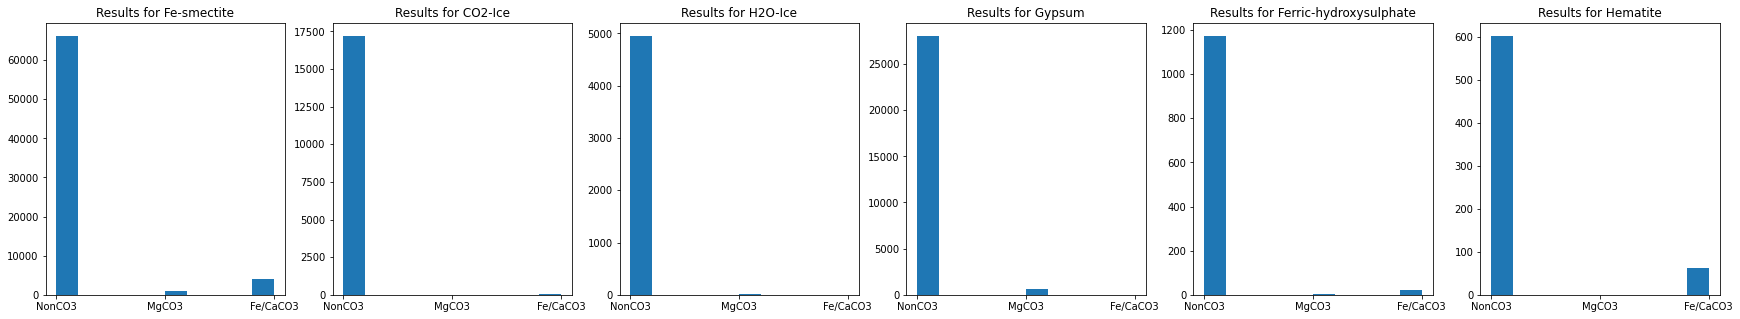

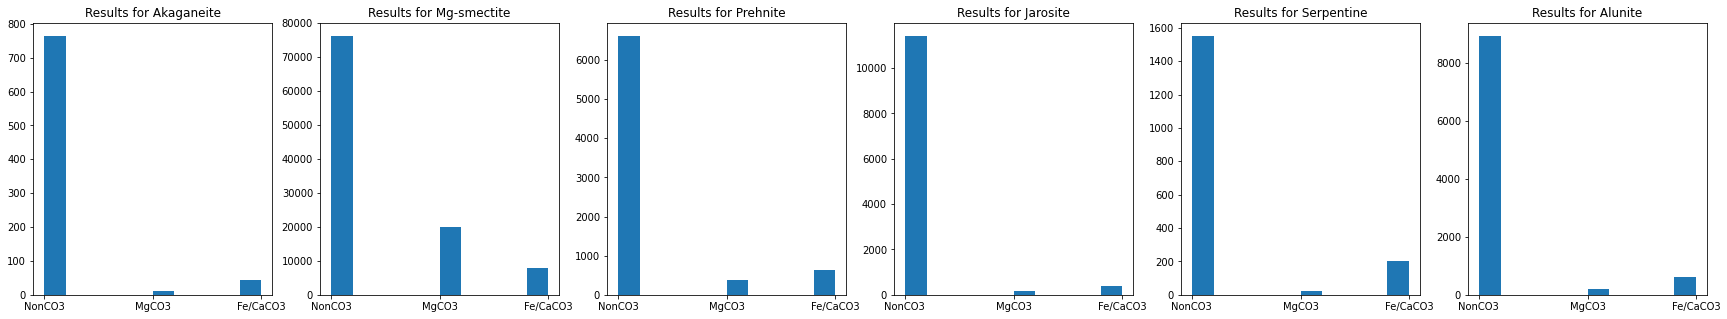

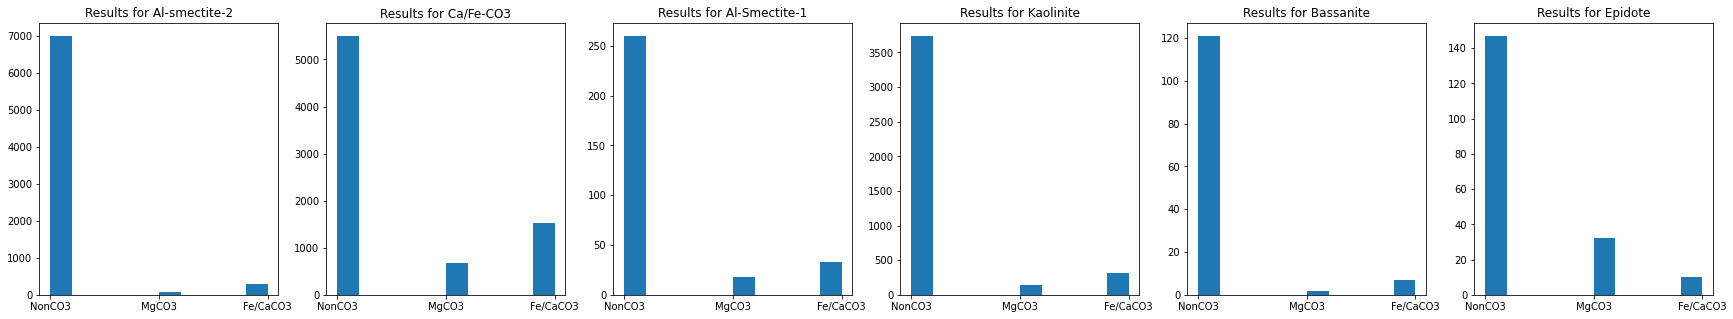

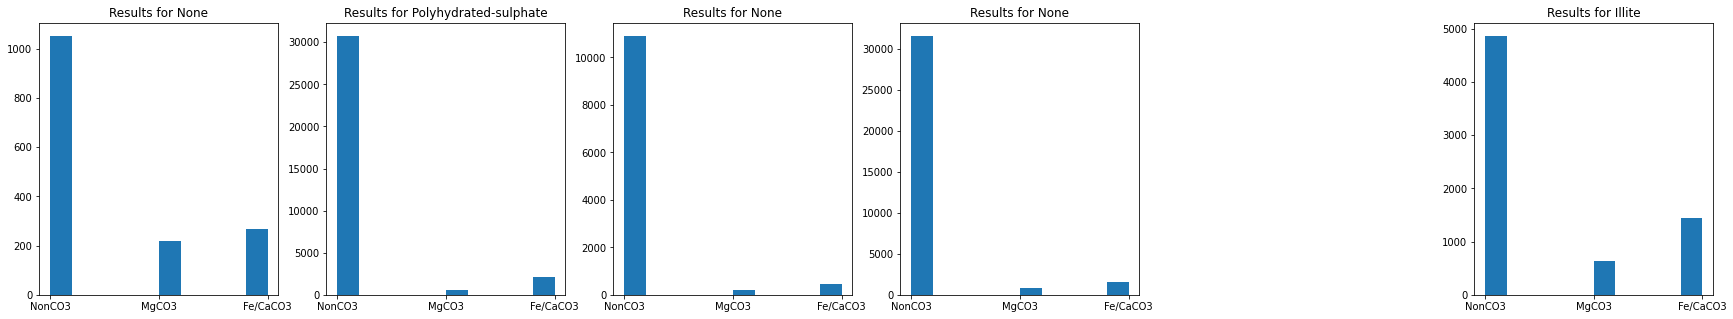

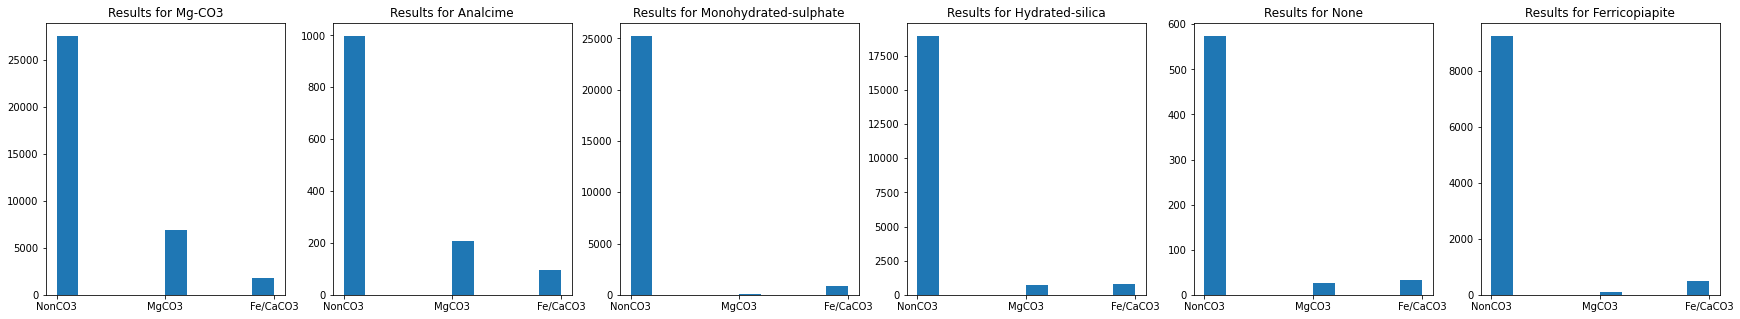

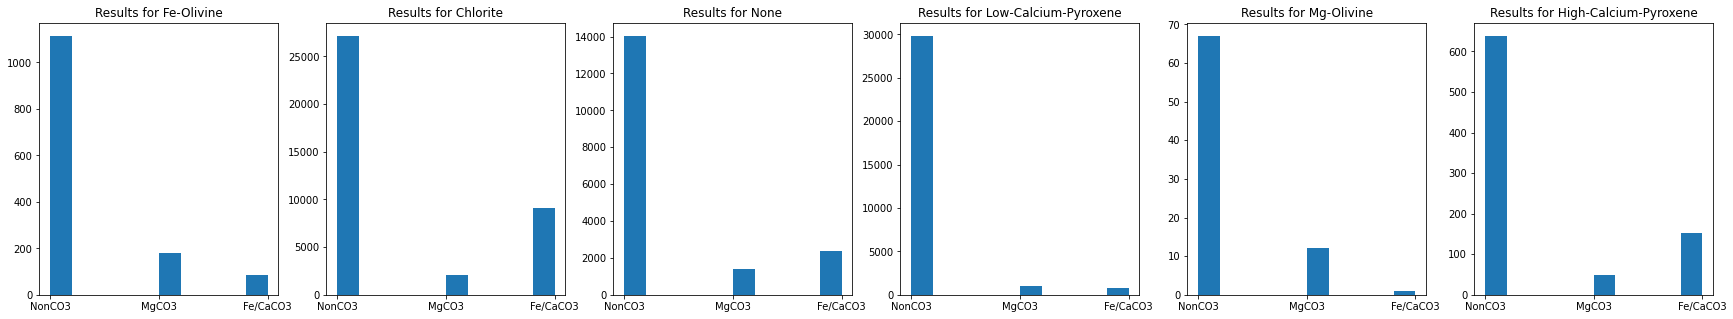

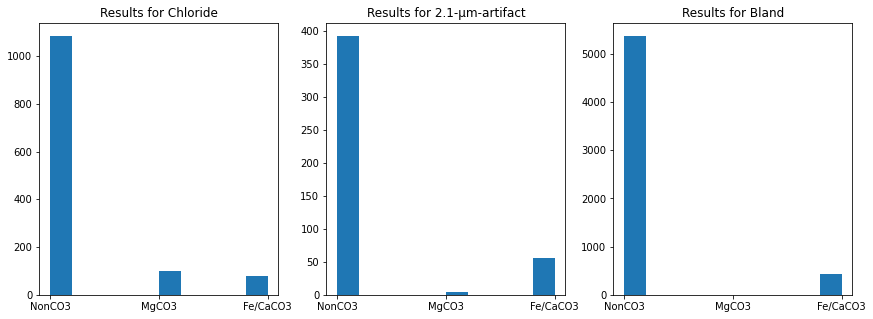

In [108]:
#specify the number of plots for each figure, i.e. per line
plotsPerFigure=6
#iterate over all unique labels
for i in uniqueLabels:
    #get indices of the current label
    currentLabelIndices=np.where(allActualLabels==i)[0]
    #get new figures for every 6th sample and new subplot for each label
    if (i-1)%plotsPerFigure==0:
        plt.figure(figsize=(30,5))
    #create sub-plot
    plt.subplot(1,plotsPerFigure,(i%plotsPerFigure)+1)
    # make things pretty
    plt.title("Results for "+labelNames[i-1])
    plt.xticks([0,1,2],
             ["NonCO3","MgCO3","Fe/CaCO3"])
    #plot the histogram
    try:
        plt.hist(allPredictedLabels[currentLabelIndices])
    except:
        pass


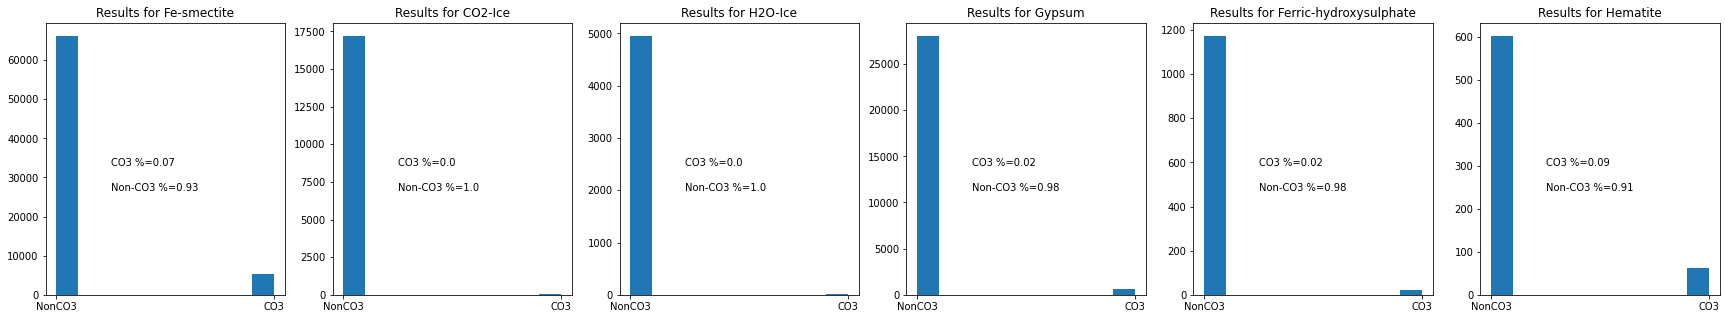

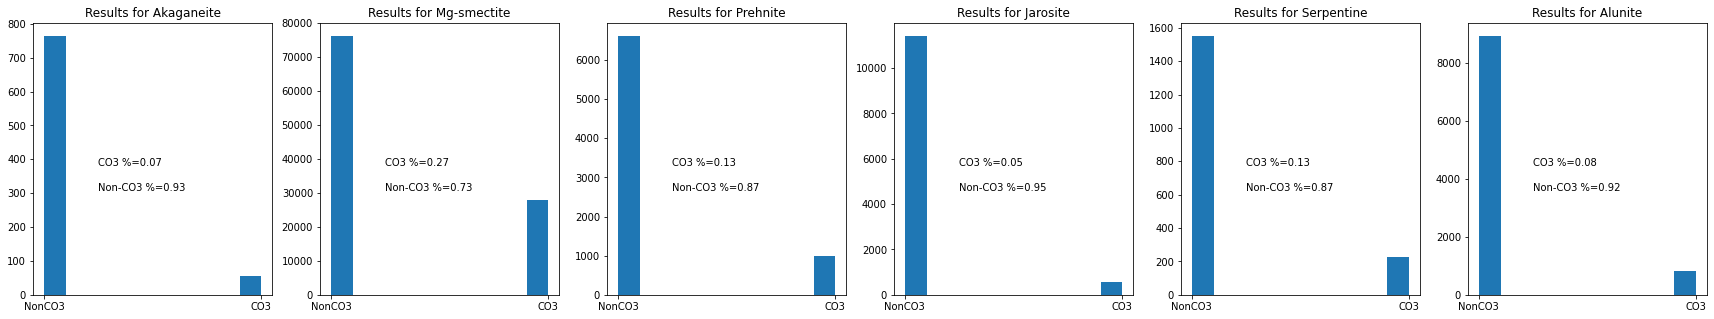

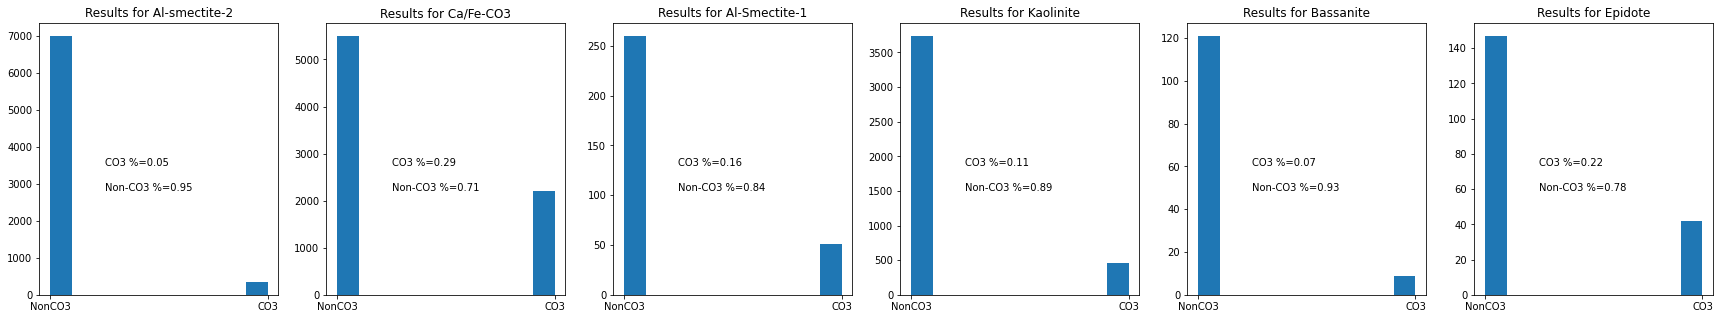

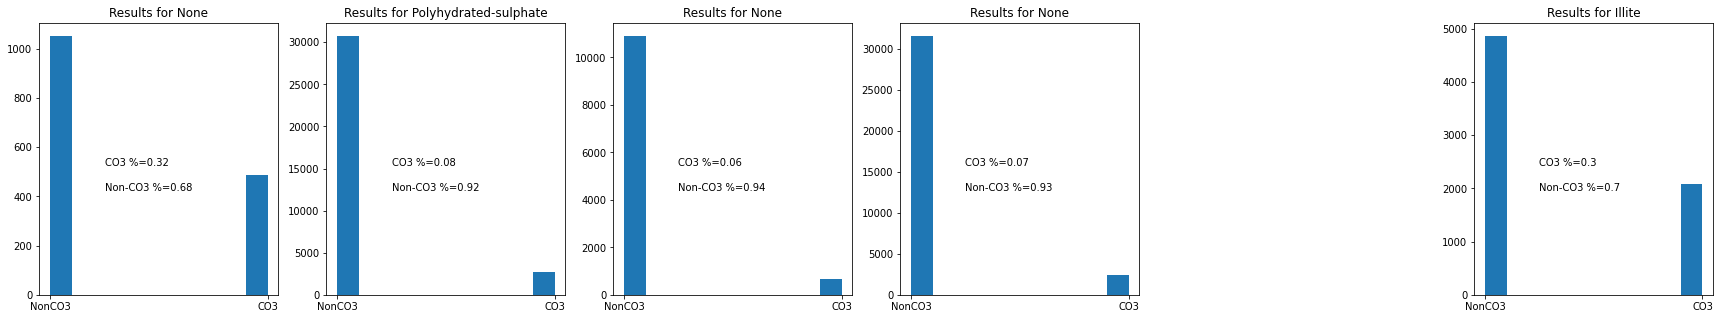

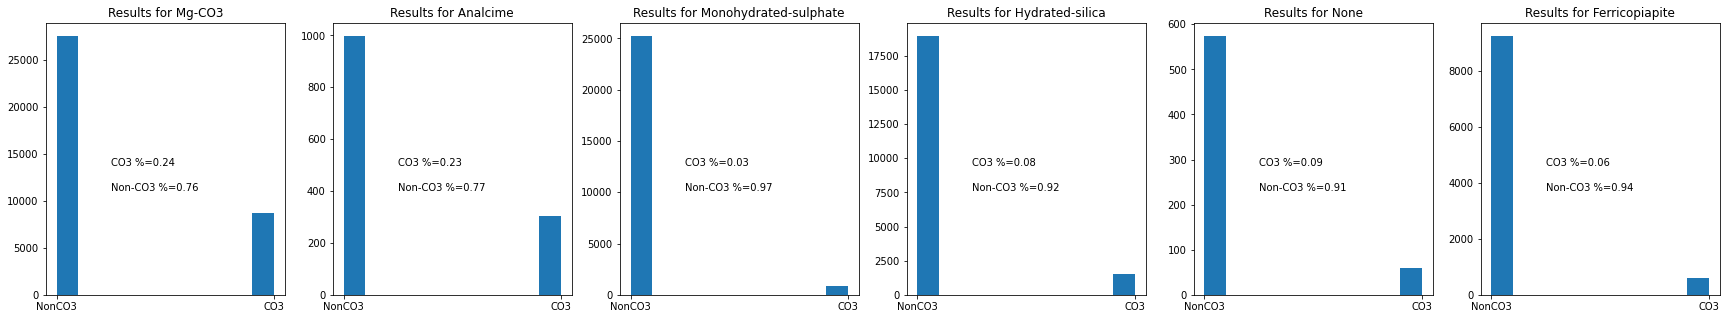

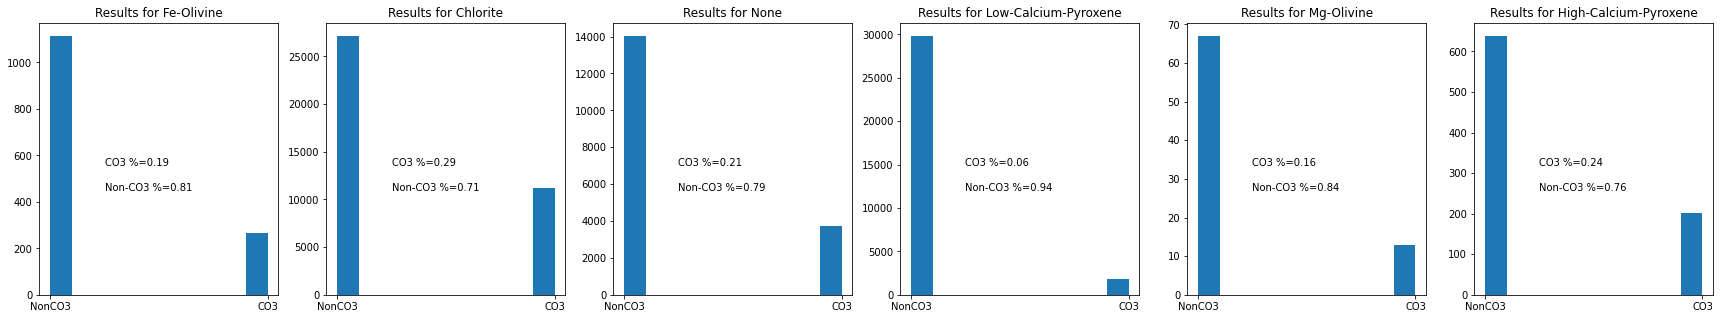

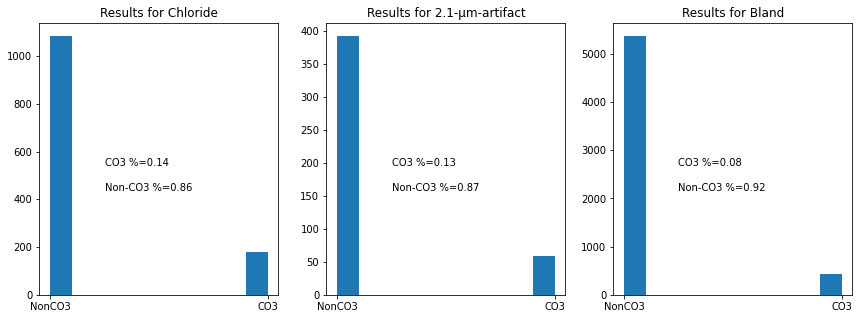

In [172]:
#specify the number of plots for each figure, i.e. per line
plotsPerFigure=6
#iterate over all unique labels
for i in uniqueLabels:
    #get indices of the current label
    currentLabelIndices=np.where(allActualLabels==i)[0]
    currentLabels=allPredictedLabels[currentLabelIndices]
    #convert labels to 0 or 1 i.e. carbonates or non-carbonates
    currentLabels=np.where(currentLabels==0,0,1)
    #get new figures for every 6th sample and new subplot for each label
    if (i-1)%plotsPerFigure==0:
        plt.figure(figsize=(30,5))
    #create sub-plot
    plt.subplot(1,plotsPerFigure,(i%plotsPerFigure)+1)
    # make things pretty
    plt.title("Results for "+labelNames[i-1])
    plt.xticks([0,1],
             ["NonCO3","CO3"])
    #plot the histogram
    try:
        plt.hist(currentLabels)
        #get percent of samples marked carbonate
        percentCarbonate=len(np.where(currentLabels==1)[0])/len(currentLabels)
        percentNonCarbonate=1-percentCarbonate
        #create message
        carbonateMessage="CO3 %="+str(round(percentCarbonate,2))
        nonCarbonateMessage="Non-CO3 %="+str(round(percentNonCarbonate,2))
        #display messages
        plt.text(0.25,max(len(np.where(currentLabels==1)[0]),len(np.where(currentLabels==0)[0]))/2,carbonateMessage,fontsize=10)
        plt.text(0.25,max(len(np.where(currentLabels==1)[0]),len(np.where(currentLabels==0)[0]))/2.5,nonCarbonateMessage,fontsize=10)
    except:
        pass


In [140]:

#create lists to hold band depth predicted value
allBandDepthPredictedLabels=[]
allMIN2295_2480=[]
allMIN2345_2537=[]
#get the indices for feCaCO3
feCaCO3Indices=np.where(allActualLabels==uniqueLabels[12])[0]
#get the indices for MgCO3
mgCO3Indices=np.where(allActualLabels==uniqueLabels[29])[0]
#iterate over all samples
for i in range(len(allActualLabels)):
    #scale the spectrum
    scaledSpectrum=normalizeSpectra(allSpectra[i])
    #process the spectra i.e. check for carbonate
    predictedLabel=-1
    try:
        MIN2295_2480,MIN2345_2537=calculateCarbonateBandDepthIndicesForSpectra(scaledSpectrum)
        if max(MIN2295_2480,MIN2345_2537)>-0.05:
            predictedLabel=1
        else:
            predictedLabel=0
    except:
        pass
    allBandDepthPredictedLabels.append(predictedLabel)
    if i%25000==0:
        print(f"{i}-Spectra processed. {i*100/len(allSampleFiles)}% Done")

0-Spectra processed. 0.0% Done
25000-Spectra processed. 4.464676373468393% Done
50000-Spectra processed. 8.929352746936786% Done
75000-Spectra processed. 13.394029120405179% Done
100000-Spectra processed. 17.858705493873572% Done
125000-Spectra processed. 22.323381867341965% Done
150000-Spectra processed. 26.788058240810358% Done
175000-Spectra processed. 31.25273461427875% Done
200000-Spectra processed. 35.717410987747144% Done
225000-Spectra processed. 40.18208736121554% Done
250000-Spectra processed. 44.64676373468393% Done
275000-Spectra processed. 49.11144010815232% Done
300000-Spectra processed. 53.576116481620716% Done
325000-Spectra processed. 58.04079285508911% Done
350000-Spectra processed. 62.5054692285575% Done
375000-Spectra processed. 66.9701456020259% Done
400000-Spectra processed. 71.43482197549429% Done
425000-Spectra processed. 75.89949834896268% Done
450000-Spectra processed. 80.36417472243107% Done
475000-Spectra processed. 84.82885109589947% Done
500000-Spectra pro

In [141]:
allBandDepthPredictedLabels=np.array(allBandDepthPredictedLabels).astype('int')

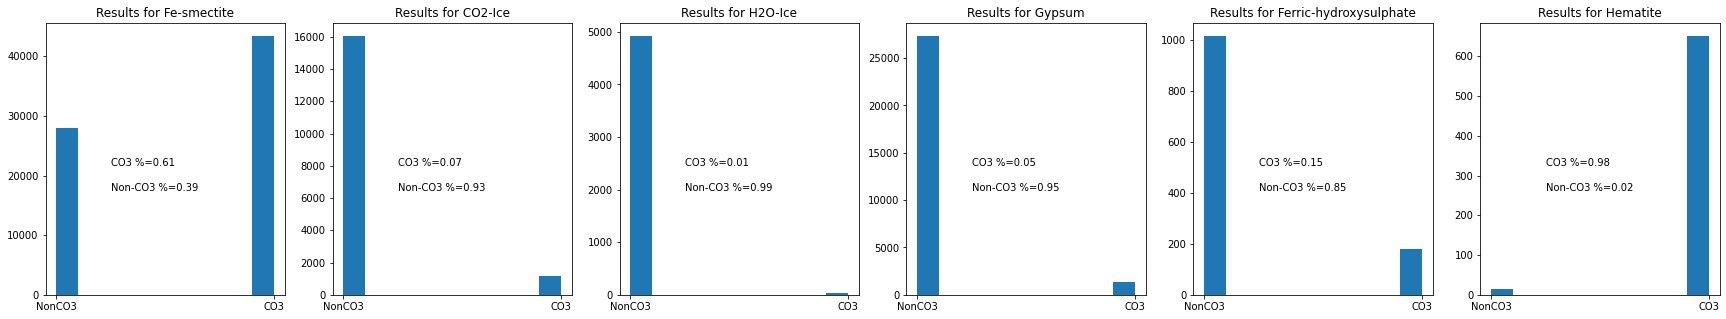

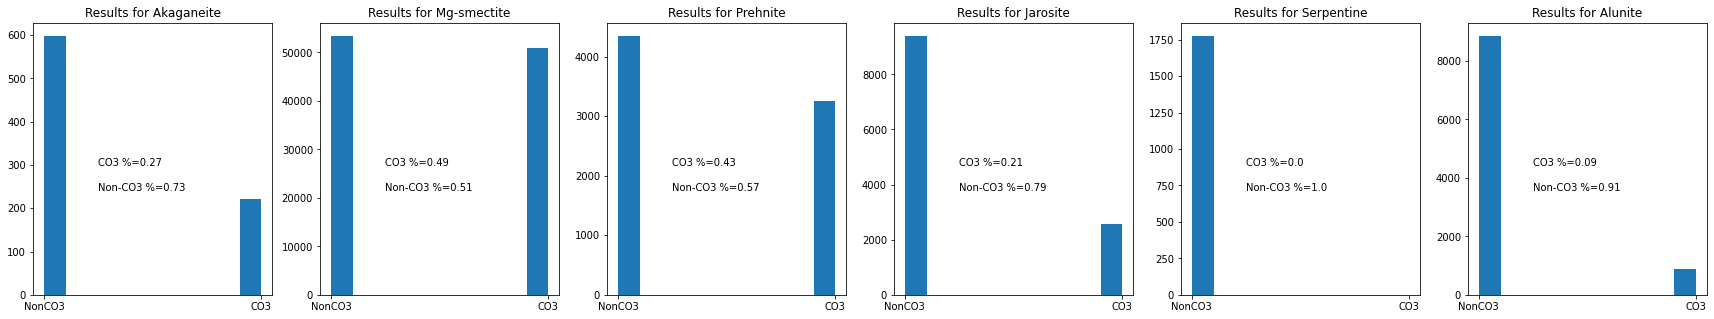

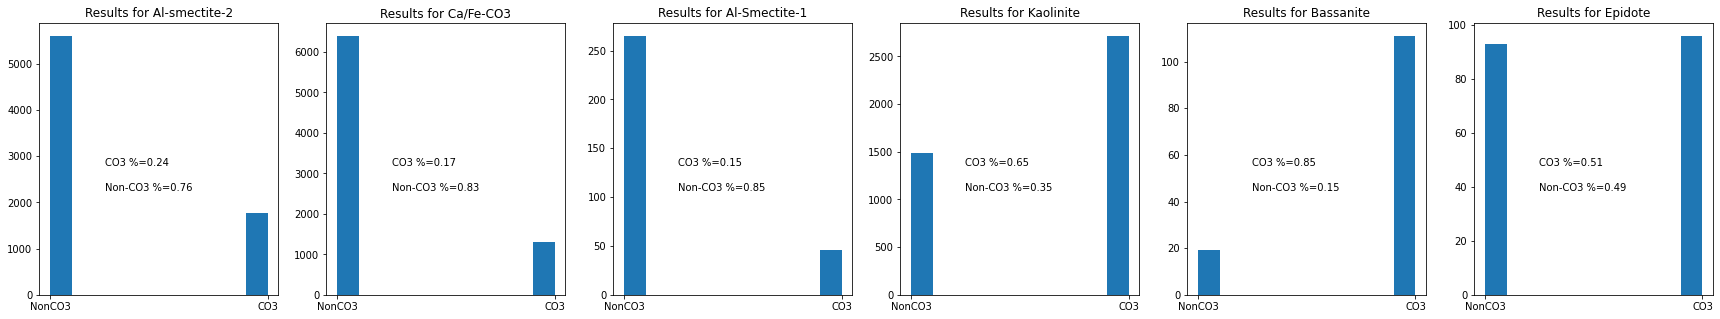

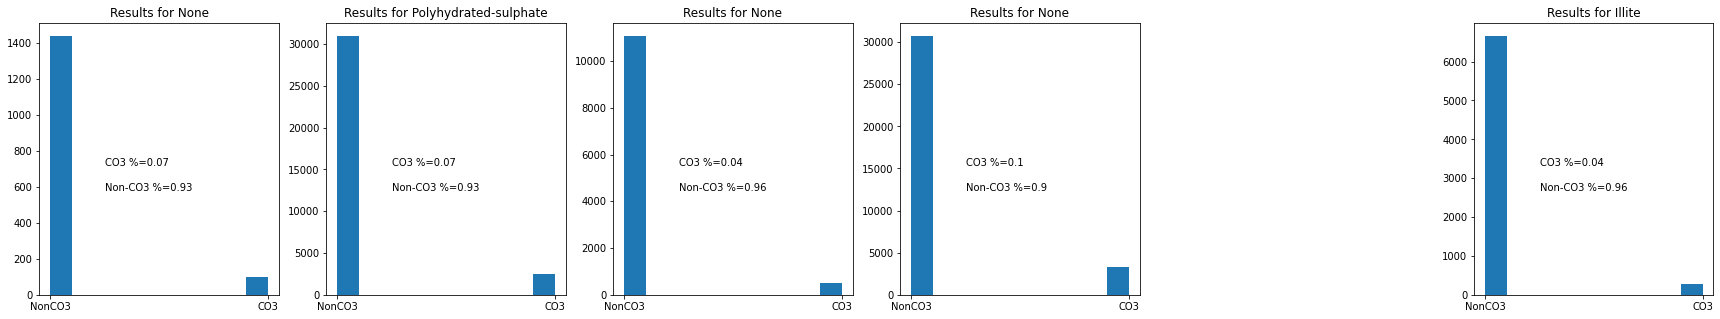

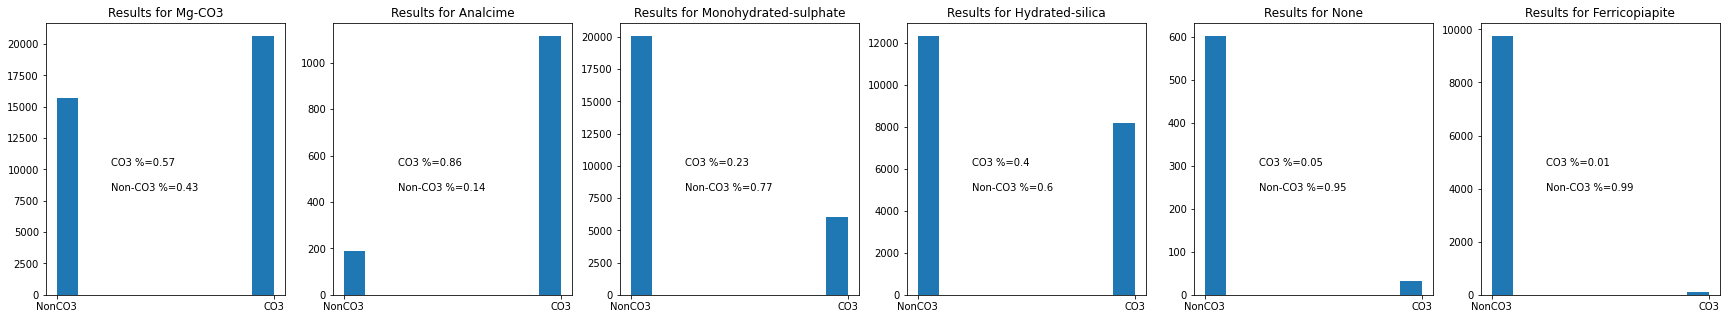

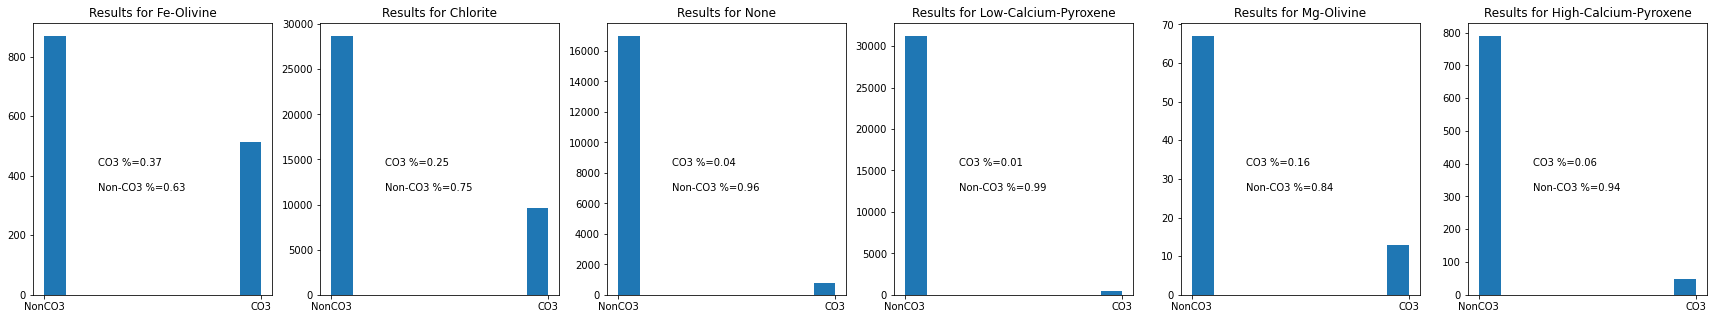

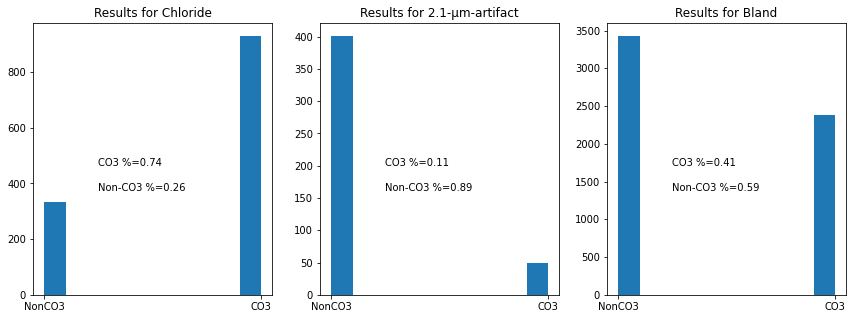

In [171]:
#specify the number of plots for each figure, i.e. per line
plotsPerFigure=6
#iterate over all unique labels
for i in uniqueLabels:
    #get indices of the current label
    currentLabelIndices=np.where(allActualLabels==i)[0]
    currentLabels=allBandDepthPredictedLabels[currentLabelIndices]
    #convert labels to 0 or 1 i.e. carbonates or non-carbonates
    currentLabels=np.where(currentLabels==0,0,1)
    #get new figures for every 6th sample and new subplot for each label
    if (i-1)%plotsPerFigure==0:
        plt.figure(figsize=(30,5))
    #create sub-plot
    plt.subplot(1,plotsPerFigure,(i%plotsPerFigure)+1)
    # make things pretty
    plt.title("Results for "+labelNames[i-1])
    plt.xticks([0,1],
             ["NonCO3","CO3"])
    #plot the histogram
    try:
        plt.hist(currentLabels)
        #get percent of samples marked carbonate
        percentCarbonate=len(np.where(currentLabels==1)[0])/len(currentLabels)
        percentNonCarbonate=1-percentCarbonate
        #create message
        carbonateMessage="CO3 %="+str(round(percentCarbonate,2))
        nonCarbonateMessage="Non-CO3 %="+str(round(percentNonCarbonate,2))
        #display messages
        plt.text(0.25,max(len(np.where(currentLabels==1)[0]),len(np.where(currentLabels==0)[0]))/2,carbonateMessage,fontsize=10)
        plt.text(0.25,max(len(np.where(currentLabels==1)[0]),len(np.where(currentLabels==0)[0]))/2.5,nonCarbonateMessage,fontsize=10)
    except:
        pass


In [158]:
#get classification results based on band centres
#create lists to hold band depth predicted value
allBandCentrePredictedLabels=[]
#iterate over all samples
for i in range(len(allActualLabels)):
    #scale the spectrum
    scaledSpectrum=normalizeSpectra(allSpectra[i])
    #process the spectra i.e. check for carbonate
    predictedLabel=-1
    carbonateFlag=checkCarbonateBandCentreBased(scaledSpectrum)
    if carbonateFlag:
        predictedLabel=1
    else:
        predictedLabel=0
    allBandCentrePredictedLabels.append(predictedLabel)

    if i%25000==0:
        print(f"{(int)(i/1000)}k-Spectra processed. {i*100/len(allSampleFiles)}% Done")

C:\Users\104D\AppData\Local\Temp/ipykernel_6676/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_6676/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


0k-Spectra processed. 0.0% Done
25k-Spectra processed. 4.464676373468393% Done
50k-Spectra processed. 8.929352746936786% Done
75k-Spectra processed. 13.394029120405179% Done
100k-Spectra processed. 17.858705493873572% Done
125k-Spectra processed. 22.323381867341965% Done
150k-Spectra processed. 26.788058240810358% Done
175k-Spectra processed. 31.25273461427875% Done
200k-Spectra processed. 35.717410987747144% Done
225k-Spectra processed. 40.18208736121554% Done
250k-Spectra processed. 44.64676373468393% Done
275k-Spectra processed. 49.11144010815232% Done
300k-Spectra processed. 53.576116481620716% Done
325k-Spectra processed. 58.04079285508911% Done
350k-Spectra processed. 62.5054692285575% Done
375k-Spectra processed. 66.9701456020259% Done
400k-Spectra processed. 71.43482197549429% Done
425k-Spectra processed. 75.89949834896268% Done
450k-Spectra processed. 80.36417472243107% Done
475k-Spectra processed. 84.82885109589947% Done
500k-Spectra processed. 89.29352746936786% Done
525k-Sp

In [159]:
allBandCentrePredictedLabels=np.array(allBandCentrePredictedLabels).astype('int')

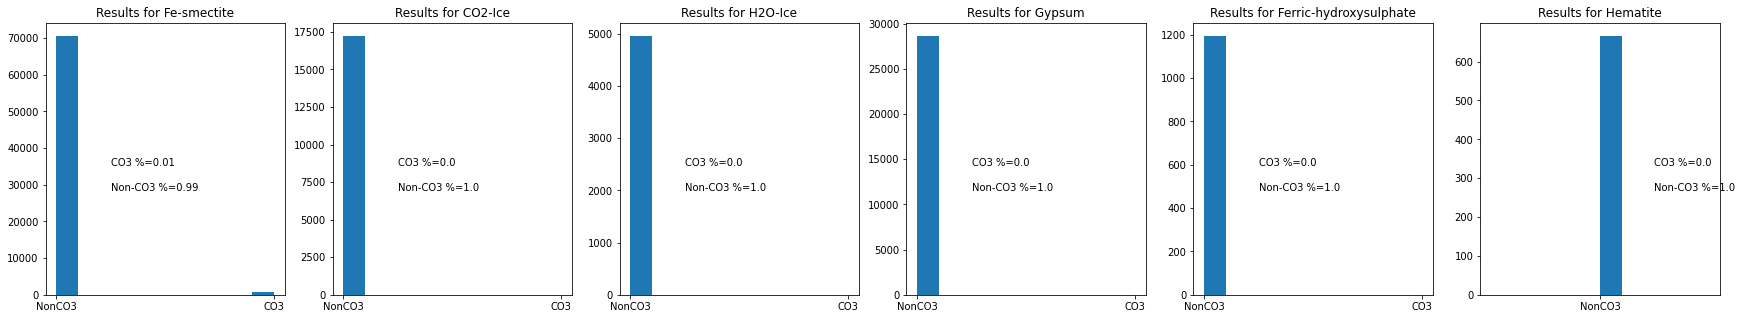

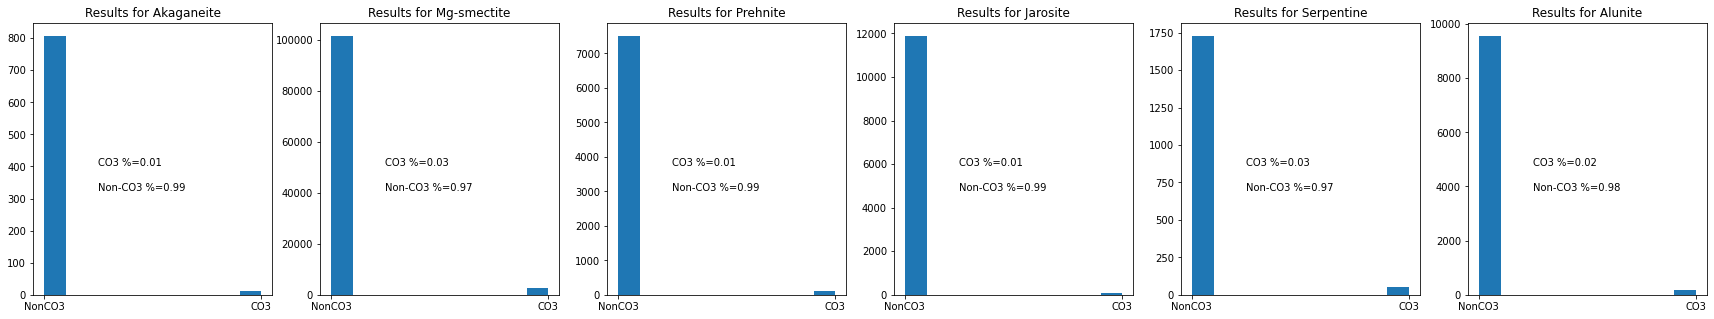

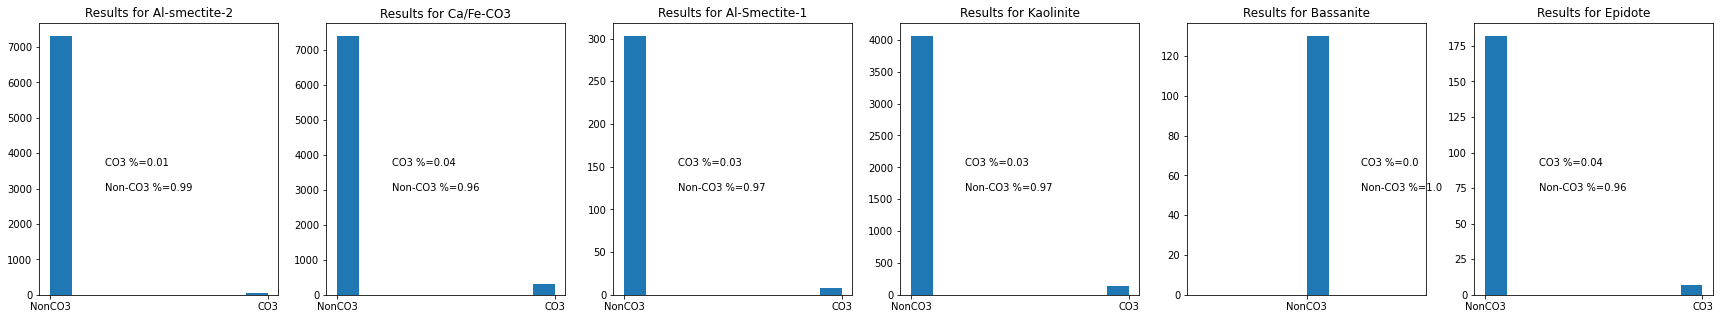

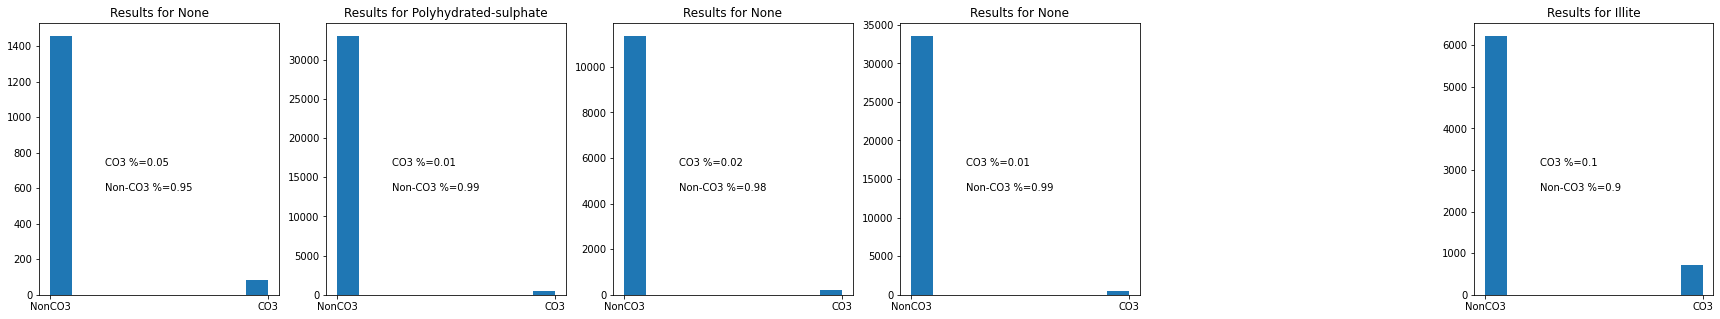

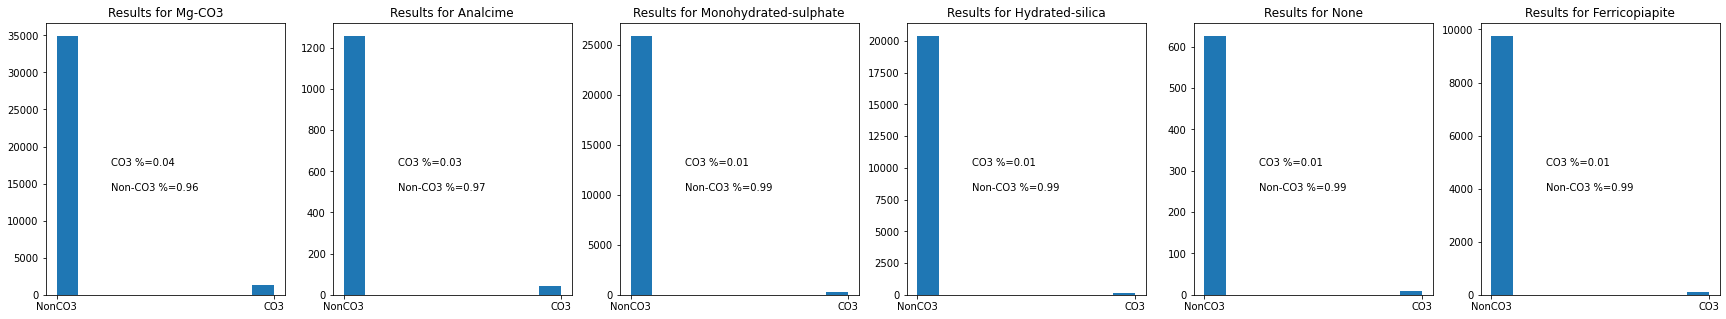

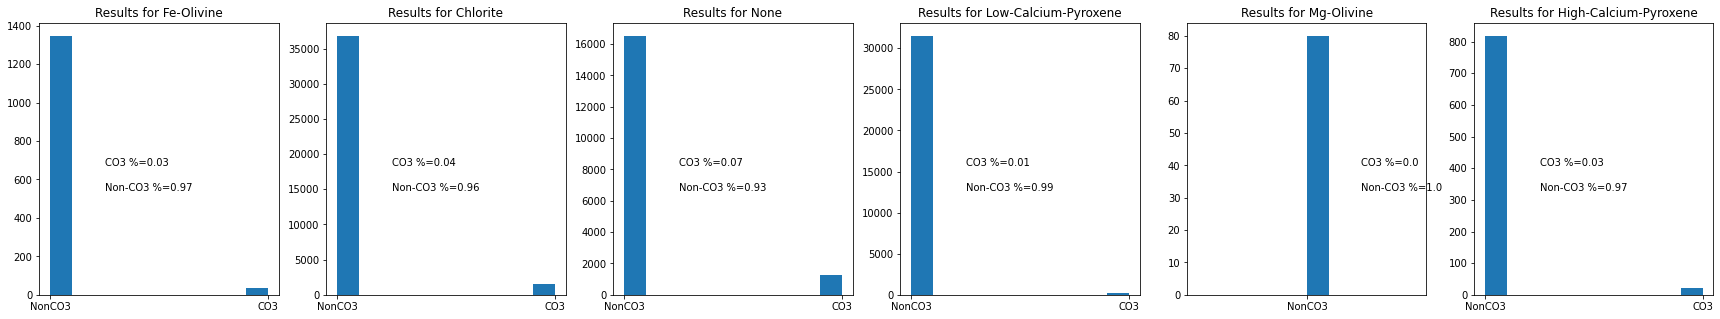

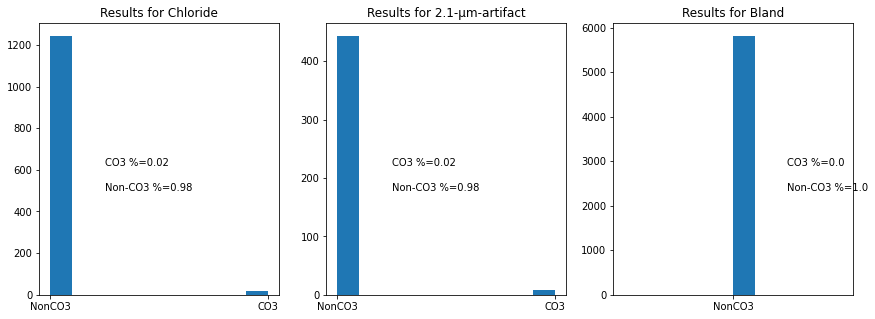

In [173]:
#specify the number of plots for each figure, i.e. per line
plotsPerFigure=6
#iterate over all unique labels
for i in uniqueLabels:
    #get indices of the current label
    currentLabelIndices=np.where(allActualLabels==i)[0]
    currentLabels=allBandCentrePredictedLabels[currentLabelIndices]
    #convert labels to 0 or 1 i.e. carbonates or non-carbonates
    currentLabels=np.where(currentLabels==0,0,1)
    #get new figures for every 6th sample and new subplot for each label
    if (i-1)%plotsPerFigure==0:
        plt.figure(figsize=(30,5))
    #create sub-plot
    plt.subplot(1,plotsPerFigure,(i%plotsPerFigure)+1)
    # make things pretty
    plt.title("Results for "+labelNames[i-1])
    plt.xticks([0,1],
             ["NonCO3","CO3"])
    #plot the histogram
    try:
        plt.hist(currentLabels)
        #get percent of samples marked carbonate
        percentCarbonate=len(np.where(currentLabels==1)[0])/len(currentLabels)
        percentNonCarbonate=1-percentCarbonate
        #create message
        carbonateMessage="CO3 %="+str(round(percentCarbonate,2))
        nonCarbonateMessage="Non-CO3 %="+str(round(percentNonCarbonate,2))
        #display messages
        plt.text(0.25,max(len(np.where(currentLabels==1)[0]),len(np.where(currentLabels==0)[0]))/2,carbonateMessage,fontsize=10)
        plt.text(0.25,max(len(np.where(currentLabels==1)[0]),len(np.where(currentLabels==0)[0]))/2.5,nonCarbonateMessage,fontsize=10)
    except:
        pass


In [193]:
#show accuracy metrics for a given regime
def getAccuracyMetrics(regime,givenLabels):
    global uniqueLabels
    global allActualLabels
    
    #get indices of all carbonate samples
    carbonateSampleLabels=[uniqueLabels[12],uniqueLabels[29]]
    carbonateIndices=np.where(np.logical_or(allActualLabels==carbonateSampleLabels[0],allActualLabels==carbonateSampleLabels[1]))[0]

    #get indices of all non-carbonate samples
    nonCarbonateIndices=np.where(np.logical_and(allActualLabels!=carbonateSampleLabels[0],allActualLabels!=carbonateSampleLabels[1]))[0]
    #get true positives
    truePostiveIndices=np.where(givenLabels[carbonateIndices]==1)[0]
    #get true negetives
    trueNegetiveIndices=np.where(givenLabels[nonCarbonateIndices]==0)[0]
    #get false negetives
    falseNegetiveIndices=np.where(givenLabels[carbonateIndices]==0)[0]
    #get false positive
    falsePositiveIndices=np.where(givenLabels[nonCarbonateIndices]==1)[0]

    #get true positive rate
    truePostiveRate=len(truePostiveIndices)/(len(truePostiveIndices)+len(falseNegetiveIndices))
    #get true negetives rate
    trueNegetiveRate=len(trueNegetiveIndices)/(len(trueNegetiveIndices)+len(falsePositiveIndices))
    #get false negetives rate
    falseNegetiveRate=len(falseNegetiveIndices)/(len(falseNegetiveIndices)+len(truePostiveIndices))
    #get false positive rate
    falsePositiveRate=len(falsePositiveIndices)/(len(falsePositiveIndices)+len(trueNegetiveIndices))
    #get overall accuracy
    overallAccuracy=(len(truePostiveIndices)+len(trueNegetiveIndices))/(len(truePostiveIndices)+len(trueNegetiveIndices)+len(falseNegetiveIndices)+len(falsePositiveIndices))


    print(f"Performance metrics for {regime} are:\tTPR:{round(truePostiveRate,2)}\tTNR:{round(trueNegetiveRate,2)}\tFPR:{round(falseNegetiveRate,2)}\tFNR:{round(falsePositiveRate,2)}\tAcc.:{round(overallAccuracy,2)}")

In [192]:
#display accuracy metrics for each of the three regimes
proposedPredictedLabels=np.where(np.logical_or(allPredictedLabels==1,allPredictedLabels==2),1,0)
regimeNames=["Band Depths","Band centre","IBG Proposed"]
outputs=[allBandDepthPredictedLabels,allBandCentrePredictedLabels,proposedPredictedLabels]
for i,j in zip(regimeNames,outputs):
    getAccuracyMetrics(i,j)

Performance metrics for Band Depths are:	TPR:0.22	TNR:0.69	FPR:0.78	FNR:0.31	Acc.:0.67
Performance metrics for Band centre are:	TPR:0.02	TNR:0.98	FPR:0.98	FNR:0.02	Acc.:0.92
Performance metrics for IBG Proposed are:	TPR:0.09	TNR:0.86	FPR:0.91	FNR:0.14	Acc.:0.81


In [194]:
#get the indices for feCaCO3
feCaCO3Indices=np.where(allActualLabels==uniqueLabels[12])[0]
#get the indices for MgCO3
mgCO3Indices=np.where(allActualLabels==uniqueLabels[29])[0]

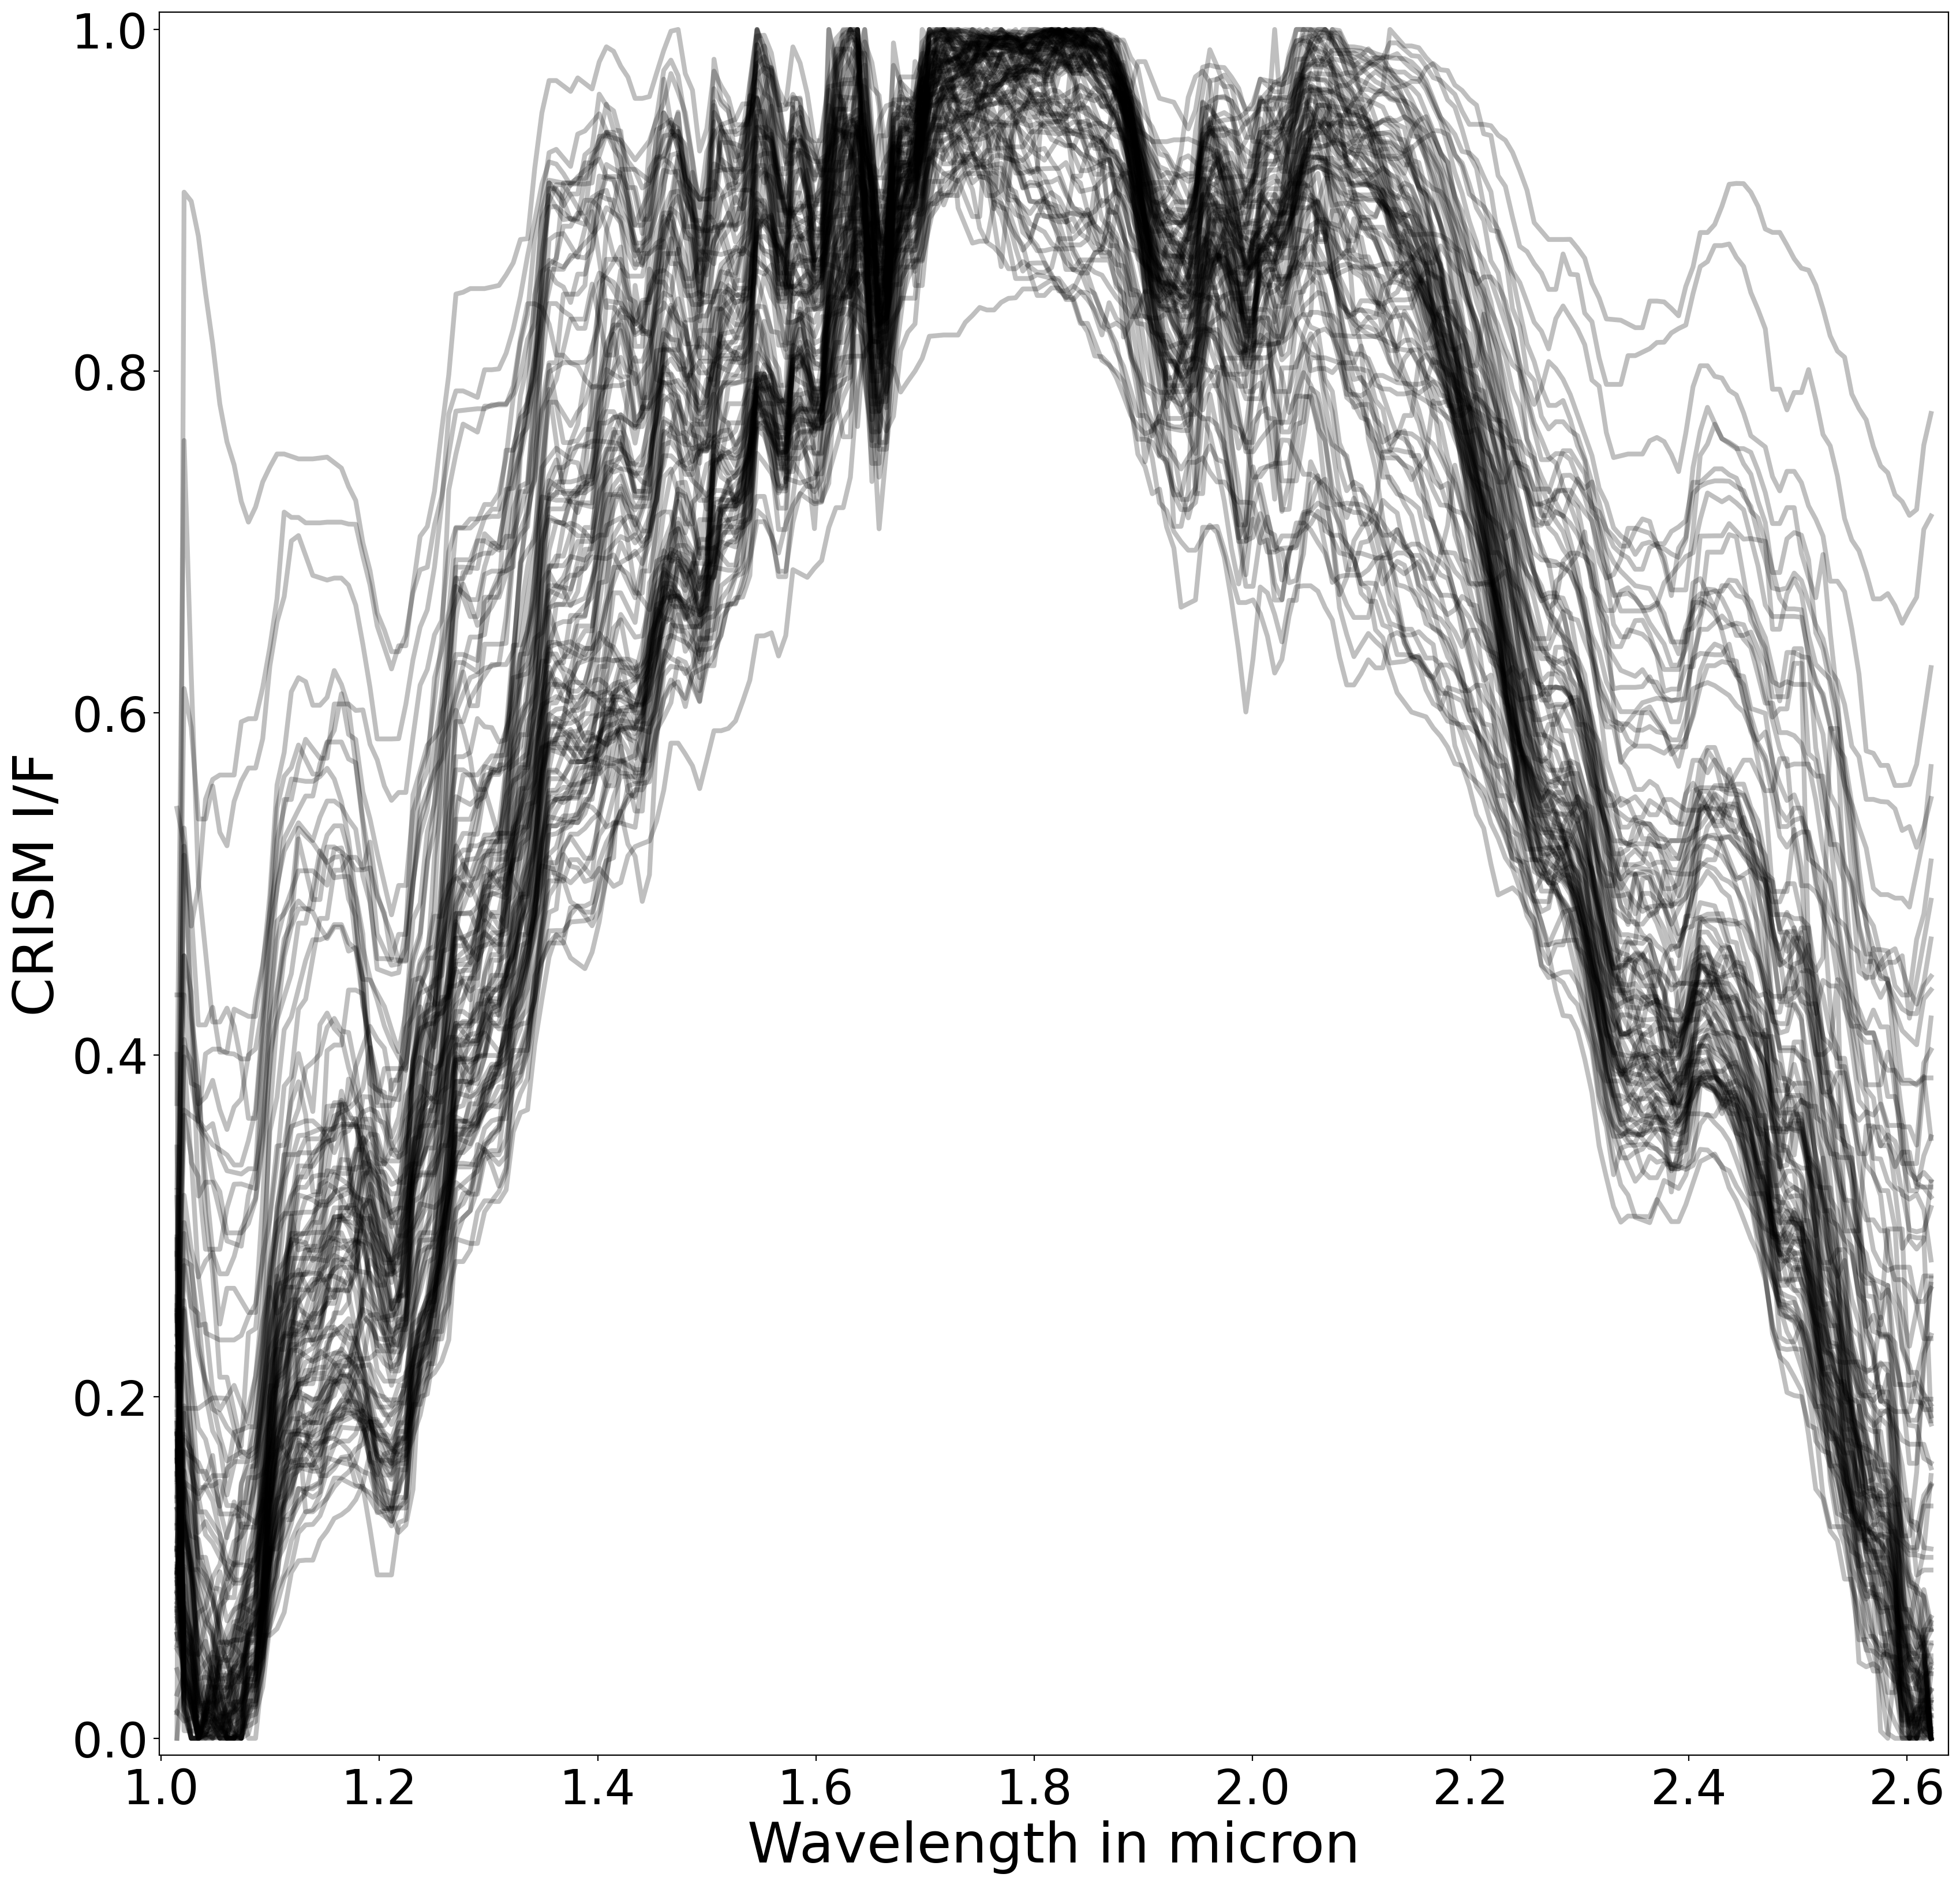

In [209]:
import random
random.shuffle(mgCO3Indices)
plt.figure(figsize=(20,20),dpi=200)
plt.xlabel("Wavelength in micron",fontsize=35)
plt.ylabel("CRISM I/F",fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
for i in range(100):
    plt.plot(wavelengthList,normalizeSpectra(allSpectra[mgCO3Indices[i]]),color='black',alpha=0.25,lw=3)
plt.margins(0.01)

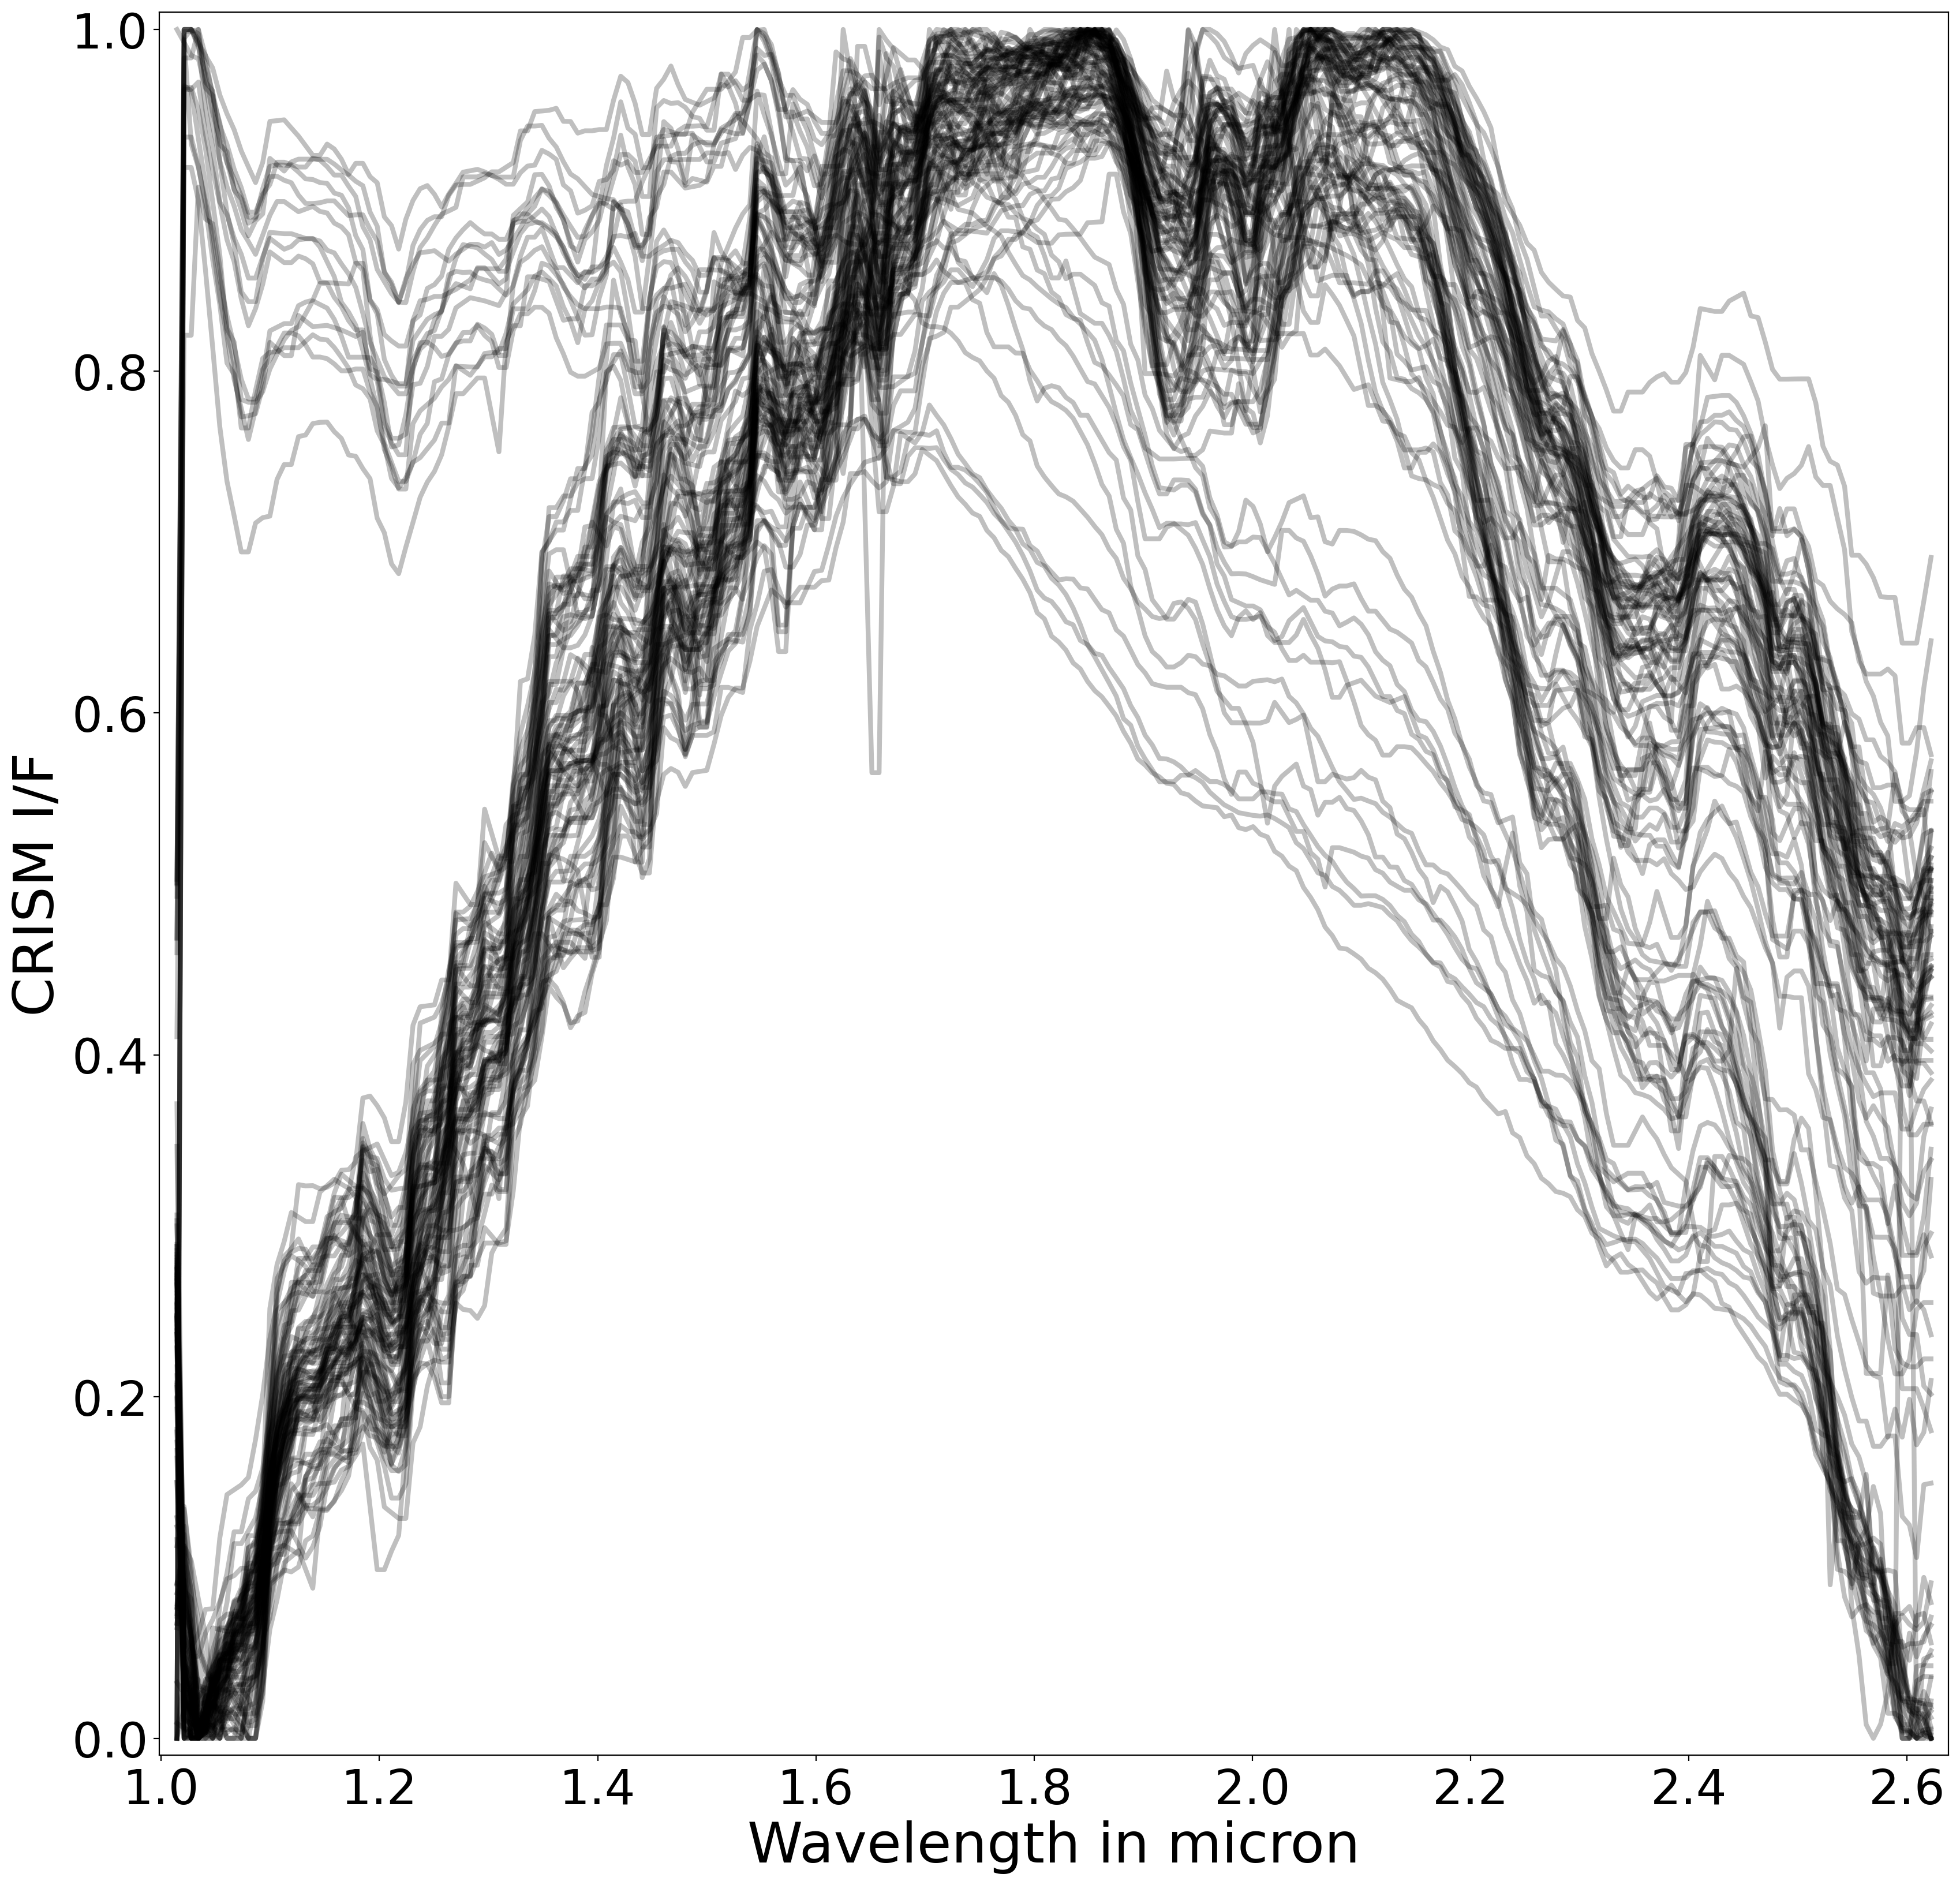

In [210]:
import random
random.shuffle(feCaCO3Indices)
plt.figure(figsize=(20,20),dpi=200)
plt.xlabel("Wavelength in micron",fontsize=35)
plt.ylabel("CRISM I/F",fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
for i in range(100):
    plt.plot(wavelengthList,normalizeSpectra(allSpectra[feCaCO3Indices[i]]),color='black',alpha=0.25,lw=3)
plt.margins(0.01)